# Sumario <a id='back'></a>

* [importando os dados](#import)

* [tratando os dados](#tratando-os-dados)

* [modificando tabelas](#modificando-tabelas)
    - [modificando tabela logs](#modificando-tabela-logs)
    - [modificando tabela compras](#modificando-tabela-compras)
    - [modificando tabela custos](#modificando-a-tabela-custos)

* [analises](#analisando-as-tabelas-e-encontrando-respostas)
* [analisando produto](#analisando-produto)

    - [seções por dia](#quantas-sessões-ocorrem-por-dia)
    - [tamanho de cada compra](#qual-o-tamanho-de-cada-sessão)
    - [frequencia](#com-que-frequencia-os-usuários-voltam)
    - [retorno](#analisando-o-retorno-dos-usuarios-por-coorte)
    - [conclusoes](#primeiras-conclusoes-parciais-do-coorte-de-acessos)
    
* [analise das compras/vendas](#analise-das-comprasvendas)
    - [quando](#quando-as-pessoas-começam-a-comprar)
    - [volume](#qual-é-o-volume-médio-de-uma-compra)
    - [quantidade de pedidos](#quantos-pedidos-os-clientes-fazem-durante-um-determinado-período-de-tempo)
* [analisando custos](#analisando-custos)
    - [quanto dinheiro foi gasto ](#quanto-dinheiro-foi-gasto-no-totalpor-origemao-longo-do-tempo)
        - [gastos no tempo](#custos-ao-longo-do-tempo)
        - [por origem](#quanto-custou-a-aquisição-de-clientes-para-cada-origem)
* [os investimentos valeram a pena?](#os-investimentos-valeram-a-pena-roi)
    - [calculando-ltv](#calculando-ltv)
    - [calculando-cac](#calculando-cac)
    - [calculando-romi](#finalmente-calculando-o-romi)

* [conclusao](#conclusoes)
    - [eficiencia de marketing](#indicando-qual-a-origem-de-marketing-que-foi-mais-eficiente)




# importando os dados <a id='import'></a>
primeiro vamos importar as bibliotecas, apos, ler os arquivos e ver suas caracteristicas.


In [1488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [1489]:
try:
    df1 = pd.read_csv('/datasets/costs_us.csv')
except:
    df1=pd.read_csv('costs_us.csv')
try:
    df2 = pd.read_csv('/datasets/orders_log_us.csv')
except:
    df2=pd.read_csv('orders_log_us.csv')

#aqui já na leitura podemos ja passar device para booliano, bem como start e end para data
try:
    df3 = pd.read_csv('/datasets/visits_log_us.csv', dtype={'Device': 'category'},parse_dates=['Start Ts', 'End Ts']) 
except:
    df3=pd.read_csv(
        'visits_log_us.csv',
         dtype={'Device': 'category'},
         parse_dates=['Start Ts', 'End Ts'],
    )




# tratando os dados <a id='trat'> </a>

[sumario](#back)

### corrigindo colunas

usamos o info() para identificar colunas com o tipo incorreto (objeto, quando deveria ser datetime), após passamos a corrigi-las!

In [1490]:
print(df1.info())
print()
print(df2.info()) 
print()
print(df3.info()) 
df1['dt']=pd.to_datetime(df1['dt'])
df2['Buy Ts']=pd.to_datetime(df2['Buy Ts'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   E

#### agora, procuramos eliminar valores absurdos custos ou receitas negativos <a id = 'absurdo'> </a>
[sumario](#back)

In [1492]:
#eliminando valores negativos
df2= df2[df2['Revenue']>0]
df1= df1[df1['costs']>0]

criamos uma função para remover os valores outliers (isso para quando formos analizar em graficos, por exemplo, será muito util)

In [1493]:
def outliers(df, coluna): 
    Q1 = df[coluna].quantile(0.25)  # Primeiro quartil
    Q3 = df[coluna].quantile(0.75)  # Terceiro quartil
    IQR = Q3 - Q1  # Intervalo Interquartil

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Removendo outliers
    df_sem_outliers = df[(df[coluna] > limite_inferior) & (df[coluna] < limite_superior)]
    return df_sem_outliers

removendo linhas duplicadas:

In [1494]:
df1=df1.drop_duplicates()
df2=df2.drop_duplicates()
df3=df3.drop_duplicates()

renomeio os dfs, que agora são conhecidos, para nomes mais intuitivos

In [1495]:
custos=df1
compras=df2
logs=df3

## modificando tabelas  
<a id='mod'></a>

[sumario](#back)

a partir daqui iremos trabalhar com os dados para fazermos a analise

### modificando tabela logs <a id= "modlog"> </a>

[sumario](#back)


vamos melhorar a tabela logs 
vamos extrair da data os dias, meses e semanas correspondentes às compras. Para depois compará-los.



queremos responder posteriormente:

     Produto 
        ◦ Quantas pessoas usam-no cada dia, semana e mês?
        ◦ Quantas sessões ocorrem por dia? (um usuário pode realizar várias sessões).
        ◦ Que comprimento tem cada sessão?
        ◦ Com que frequência os usuários voltam?
   

In [1496]:
logs= logs.rename(columns={"End Ts": "fim", "Start Ts": "inicio"}) 

faremos uma subtração do dia do acesso pelo dia mais antigo, assim saberemos quantos dias se passaram da data do acesso para o inicio da coleta de dados. 


In [1497]:
logs.head(5)

,Device,fim,Source Id,inicio,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [1498]:
logs['dia'] = logs['inicio'].dt.date
#agora se subtrai a data inicial da data de cada dado e se extrai só a quantidade de dias resultante 
logs['dia'] = (logs['dia'] - logs['dia'].min()).apply(lambda x: x.days)



agora se cria o mes

In [1499]:
# Calcula a diferença em meses desde a data mínima até cada data na coluna 'inicio'
logs['mes'] = (logs['inicio'] - logs['inicio'].min()) // pd.Timedelta(days=30)

# Adiciona 1 a cada valor de mês calculado para iniciar a contagem de meses a partir de 1
logs['mes'] += 1



preciso fazer o mesmo para semana, aqui aproveito a coluna dia, subtraio do dia da semana correspondente, 



In [1500]:
logs['semana']=logs['dia']-(logs['inicio'].dt.dayofweek)


verifico os dados para saber quantos dias eu tenho que acrescentar para que todos os numeros sejam >0 e divisiveis por 7

In [1501]:
print(logs[['semana','inicio']].sort_values(by='semana'))

        semana              inicio
162187      -3 2017-06-02 16:13:00
156661      -3 2017-06-04 23:44:00
315487      -3 2017-06-02 16:40:00
260322      -3 2017-06-03 12:15:00
260382      -3 2017-06-01 02:42:00
...        ...                 ...
320815     361 2018-05-29 13:32:00
232664     361 2018-05-31 10:48:00
176652     361 2018-05-30 22:55:00
126070     361 2018-05-30 22:45:00
221835     361 2018-05-31 09:11:00

[359400 rows x 2 columns]


faço a adição, divido por 7 

In [1502]:

logs['semana']=(logs['semana']+10)/7

transformo a coluna para tipo inteiro. 

In [1503]:
logs['semana']=logs['semana'].astype(int)

In [1504]:
logs.sort_values(by='semana')

,Device,fim,Source Id,inicio,Uid,dia,mes,semana
162187,desktop,2017-06-02 16:22:00,5,2017-06-02 16:13:00,14707501378117539046,1,1,1
156661,desktop,2017-06-04 23:54:00,3,2017-06-04 23:44:00,18228780846507422717,3,1,1
315487,touch,2017-06-02 16:40:00,4,2017-06-02 16:40:00,4679147192634550554,1,1,1
260322,touch,2017-06-03 12:30:00,10,2017-06-03 12:15:00,2200675202057710261,2,1,1
260382,touch,2017-06-01 02:43:00,4,2017-06-01 02:42:00,5608443227816432757,0,1,1
...,...,...,...,...,...,...,...,...
320815,touch,2018-05-29 14:08:00,1,2018-05-29 13:32:00,14116472251236678364,362,13,53
232664,desktop,2018-05-31 10:49:00,3,2018-05-31 10:48:00,15365864459238171476,364,13,53
176652,desktop,2018-05-30 22:57:00,4,2018-05-30 22:55:00,12202138307702225005,363,13,53
126070,touch,2018-05-30 22:49:00,10,2018-05-30 22:45:00,5456344711312502229,363,13,53


Agora vamos encontrar quantos usam o produto por semana mes e dia.  
Para tanto vou usar dados da tabela e criar uma nova tabela dinâmica com groupby opto por usar nunique pois quero o numero de usuarios, não de compras.   
uso nomes curtos abreviando 'usuario por' para 'u_p_', pois não quero minha tabela desnecessariamente larga.

In [1505]:
u_p_semana=logs.groupby('semana').agg({'Uid': 'nunique'}).reset_index()
u_p_semana.columns=['semana', 'u_p_semana']

In [1506]:
u_p_mes=logs.groupby('mes').agg({'Uid': 'nunique'}).reset_index()
u_p_mes.columns=['mes', 'u_p_mes']

In [1507]:
u_p_dia=logs.groupby('dia').agg({'Uid': 'nunique'}).reset_index()
u_p_dia.columns=['dia', 'u_p_dia']

aqui é só juntar os objetos com a tabela

In [1508]:
logs=pd.merge(logs, u_p_semana, on='semana')
logs=pd.merge(logs, u_p_mes, on='mes')
logs=pd.merge(logs, u_p_dia, on='dia')
logs.head()

,Device,fim,Source Id,inicio,Uid,dia,mes,semana,u_p_semana,u_p_mes,u_p_dia
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,202,7,30,7172,31062,1173
1,desktop,2017-12-20 02:14:00,1,2017-12-20 01:53:00,2797324142130822309,202,7,30,7172,31062,1173
2,desktop,2017-12-20 10:57:00,4,2017-12-20 10:54:00,2595451790652173532,202,7,30,7172,31062,1173
3,touch,2017-12-20 18:53:00,3,2017-12-20 18:50:00,15499483512161066509,202,7,30,7172,31062,1173
4,desktop,2017-12-20 22:36:00,5,2017-12-20 22:19:00,8227366664006369899,202,7,30,7172,31062,1173


é interessante encontrarmos também quantas seções por dia houveram, faremos o mesmo procedimento de antes, dessa vez com count no lugar de nunique

In [1509]:
s_dia=logs.groupby('dia').agg({'Uid':'count'}).reset_index()
s_dia.columns=['dia', 's_dia']
#s_dia,u_p_dia


In [1510]:
logs=pd.merge(logs, s_dia, on= 'dia')


vamos descobrir o tempo de uso de cada sessão em seg''

In [1511]:
#criando a coluna tempo'' que simbolisa o tempo em segundos:
logs["tempo''"]=logs['fim']-logs['inicio']
logs["tempo''"]=logs["tempo''"].dt.days*24*60+logs["tempo''"].dt.seconds
logs["tempo''"]=logs["tempo''"].astype(int)


agora para dividir os dados em coortes criaremos a coluna acesso1 para indicar a data do primeiro acesso.
Posteriormente, usaremos a coluna de base para outros calculos.

para fazer isso faremos uma tabela dinamica (pivot_table) para encontrar o valor da data(inicio) minima (min)de acesso por usuario(Uid)

In [1512]:
acesso1=logs.pivot_table(index='Uid',values='inicio',aggfunc='min').reset_index()
acesso1.columns=['Uid','acesso1']
logs = pd.merge(logs,acesso1, on='Uid')

In [1513]:
teste=logs.pivot_table(index='Uid',values='mes',aggfunc='min').reset_index()
teste.columns=['Uid','mes_a1']
logs = pd.merge(logs,teste, on='Uid')
#vejamos como está a tablea
logs

,Device,fim,Source Id,inicio,Uid,dia,mes,semana,u_p_semana,u_p_mes,u_p_dia,s_dia,tempo'',acesso1,mes_a1
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,202,7,30,7172,31062,1173,1276,1080,2017-12-20 17:20:00,7
1,desktop,2017-12-20 02:14:00,1,2017-12-20 01:53:00,2797324142130822309,202,7,30,7172,31062,1173,1276,1260,2017-12-20 01:53:00,7
2,desktop,2017-12-20 10:57:00,4,2017-12-20 10:54:00,2595451790652173532,202,7,30,7172,31062,1173,1276,180,2017-10-31 12:15:00,6
3,desktop,2018-02-02 12:59:00,4,2018-02-02 12:48:00,2595451790652173532,246,9,36,8111,30328,1378,1527,660,2017-10-31 12:15:00,6
4,desktop,2017-10-31 13:02:00,4,2017-10-31 12:15:00,2595451790652173532,152,6,23,7480,32721,1259,1366,2820,2017-10-31 12:15:00,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-10-01 00:47:00,5,2017-10-01 00:45:00,9409229324147845802,122,5,18,6241,28284,848,895,120,2017-10-01 00:45:00,5
359396,touch,2017-10-01 08:16:00,4,2017-10-01 08:16:00,8593319047269425674,122,5,18,6241,28284,848,895,0,2017-10-01 08:16:00,5
359397,desktop,2017-10-01 23:38:00,1,2017-10-01 23:33:00,6252400409031867415,122,5,18,6241,28284,848,895,300,2017-10-01 23:33:00,5
359398,desktop,2017-10-01 11:34:00,5,2017-10-01 11:24:00,3319790345971826479,122,5,18,6241,28284,848,895,600,2017-10-01 11:24:00,5


## modificando tabela compras

também trabalharemos a tabela compras, com procedimentos semelhantes
chamaremos a coluna da data da primeira compra de compra1
iremos também juntar a coluna do dia 1 de acesso à tabela compras
por fim, calculamos quanto tempo demorou para converter o primeiro acesso em primeira compra, em dias

iremos depois responder:

     Vendas 
        ◦ Quando as pessoas começam a comprar? (Na análise de KPIs, nós geralmente estamos interessados em saber o período de tempo entre o registro e a conversão - quando o usuário se torna um cliente. Por exemplo, se o registro e a primeira compra de um usuário ocorrem no mesmo dia, ele pode encaixar na categoria de Conversão 0d. Se a compra é realizada no dia seguinte, isso será a Conversão 1d. Você pode usar qualquer abordagem que permita comparar as conversões de diferentes coortes, para que você possa determinar qual coorte ou canal de marketing tem a maior eficiência)
        
        ◦ Quantos pedidos os clientes fazem durante um determinado período de tempo?
        ◦ Qual é o volume médio de uma compra?
        ◦ Quanto dinheiro eles trazem para a empresa (LTV)?

vamos extrair da data os dias, meses e semanas, relativos ao inicio da coleta de dados, correspondentes às compras. Para depois compará-los.


 subtraio os valores do valor minimo, divido tudo por np.timedelta64(1,'D').astype('int'), o que significa, em termos aproximados, que estou dividindo o tempo por 24h, para saber em qual dia relativo a data inicial, foi realizada a compra.   
 Assim obtemos o dia da compra relativo ao inicio da coleta de dados.

In [1514]:
compras['dia'] = (compras['Buy Ts'] - compras['Buy Ts'].min()) // np.timedelta64(1, 'D')
# Arredonda para o mês mais próximo
compras['dia'] = compras['dia'].astype(int)

# Adiciona 1 para que o primeiro mês seja 1 ao invés de 0
compras['dia'] += 1
compras['dia'].sort_values


<bound method Series.sort_values of 0          1
1          1
2          1
3          1
4          1
        ... 
50410    365
50411    365
50412    365
50413    365
50414    365
Name: dia, Length: 50364, dtype: int32>

Aqui, subtraio os valores do valor minimo, divido tudo por np.timedelta64(1,'M').astype('int'), o que significa, em termos aproximados, que estou dividindo a quantidade de dias por 30, para saber em qual mês relativo ao dia 1/06/2017, foi realizada a compra.  
Assim obtemos o mês da compra relativo ao inicio da coleta de dados

In [1515]:

# Calcula o mês relativo ao início (não há necessidade de converter para datetime64[M])
compras['mes'] = (compras['Buy Ts'] - compras['Buy Ts'].min()) // np.timedelta64(1, 'M')

# Arredonda para o mês mais próximo
compras['mes'] = compras['mes'].astype(int)

# Adiciona 1 para que o primeiro mês seja 1 ao invés de 0
compras['mes'] += 1



preciso fazer o mesmo para semana, aproveito a coluna dia, subtraio do dia da semana correspondente, verifico os dados para saber quantos dias eu tenho que acrescentar para que todos os numeros sejam >0 e divisiveis por 7, faço a adição, divido por 7 e transformo a coluna para tipo inteiro. no final, para não trabalhar com valores de dia e mes nulos, somo 1.

In [1516]:
compras=compras.rename(columns={'Buy Ts':'data'})


compras['data'].dt.dayofweek

In [1517]:
compras['semana']=compras['dia']-(compras['data'].dt.dayofweek)


In [1518]:
compras['semana']=(compras['semana'] +10) /7


In [1519]:
compras['semana']=compras['semana'].astype('int')
compras['dia']=compras['dia']+1
compras['mes']=compras['mes']+1

In [1520]:

compras=pd.merge(compras,logs[['Uid','acesso1']], on='Uid', how='left')


In [1521]:
compras['data']=pd.to_datetime(compras['data'])

In [1522]:
compras=compras.drop_duplicates()
print(len(compras))

50364


In [1523]:
compra1= compras.groupby('Uid').agg({'data':'min'}).reset_index()
compra1.columns=['Uid', 'compra1']
compras=pd.merge(compras,compra1, on='Uid')


In [1524]:
compras['data']= compras['data'].dt.date
print(compras.info())
compras['compra1']= compras['compra1'].dt.date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50364 entries, 0 to 50363
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     50364 non-null  object        
 1   Revenue  50364 non-null  float64       
 2   Uid      50364 non-null  uint64        
 3   dia      50364 non-null  int32         
 4   mes      50364 non-null  int32         
 5   semana   50364 non-null  int32         
 6   acesso1  50364 non-null  datetime64[ns]
 7   compra1  50364 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(3), object(1), uint64(1)
memory usage: 2.5+ MB
None


achando o tempo de conversão

In [1525]:
compras['conversao']=compras['compra1']-compras['acesso1'].dt.date
compras['conversao']=compras['conversao'].apply(lambda x: x.days)
compras['conversao']=compras['conversao'].astype(int) +1

In [1526]:
#agora, vamos dividir esses valores de acordo com o correspondente mes relativo ao inicio da coleta de dados 
# vamos armazenar isso em uma nova coluna

In [1527]:
compras['acesso1']=compras['acesso1'].dt.date

In [1528]:
compras['compra1'] = pd.to_datetime(compras['compra1'])

In [1529]:
compras

,data,Revenue,Uid,dia,mes,semana,acesso1,compra1,conversao
0,2017-06-01,17.00,10329302124590727494,2,2,1,2017-06-01,2017-06-01,1
1,2017-06-01,0.55,11627257723692907447,2,2,1,2017-06-01,2017-06-01,1
2,2017-06-01,0.37,17903680561304213844,2,2,1,2017-06-01,2017-06-01,1
3,2017-06-01,0.55,16109239769442553005,2,2,1,2017-06-01,2017-06-01,1
4,2017-06-01,0.37,14200605875248379450,2,2,1,2017-06-01,2017-06-01,1
...,...,...,...,...,...,...,...,...,...
50359,2018-05-31,4.64,12296626599487328624,366,13,53,2018-05-31,2018-05-31,1
50360,2018-05-31,5.80,11369640365507475976,366,13,53,2018-05-31,2018-05-31,1
50361,2018-05-31,0.30,1786462140797698849,366,13,53,2018-05-31,2018-05-31,1
50362,2018-05-31,3.67,3993697860786194247,366,13,53,2017-10-23,2018-05-31,221


In [1530]:
compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50364 entries, 0 to 50363
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   data       50364 non-null  object        
 1   Revenue    50364 non-null  float64       
 2   Uid        50364 non-null  uint64        
 3   dia        50364 non-null  int32         
 4   mes        50364 non-null  int32         
 5   semana     50364 non-null  int32         
 6   acesso1    50364 non-null  object        
 7   compra1    50364 non-null  datetime64[ns]
 8   conversao  50364 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(4), object(2), uint64(1)
memory usage: 2.7+ MB


In [1531]:
# Convertendo para períodos mensais
compras['data']=pd.to_datetime(compras['data'])
compras['compra1m']=(compras['compra1']-compras['data'].min()) // np.timedelta64(1, 'M')

In [1532]:
compras['compra1m']=compras['compra1m'].astype('int') + 1

In [1533]:
compras

,data,Revenue,Uid,dia,mes,semana,acesso1,compra1,conversao,compra1m
0,2017-06-01,17.00,10329302124590727494,2,2,1,2017-06-01,2017-06-01,1,1
1,2017-06-01,0.55,11627257723692907447,2,2,1,2017-06-01,2017-06-01,1,1
2,2017-06-01,0.37,17903680561304213844,2,2,1,2017-06-01,2017-06-01,1,1
3,2017-06-01,0.55,16109239769442553005,2,2,1,2017-06-01,2017-06-01,1,1
4,2017-06-01,0.37,14200605875248379450,2,2,1,2017-06-01,2017-06-01,1,1
...,...,...,...,...,...,...,...,...,...,...
50359,2018-05-31,4.64,12296626599487328624,366,13,53,2018-05-31,2018-05-31,1,12
50360,2018-05-31,5.80,11369640365507475976,366,13,53,2018-05-31,2018-05-31,1,12
50361,2018-05-31,0.30,1786462140797698849,366,13,53,2018-05-31,2018-05-31,1,12
50362,2018-05-31,3.67,3993697860786194247,366,13,53,2017-10-23,2018-05-31,221,12


In [1534]:
compras['acesso1']=pd.to_datetime(compras['acesso1'])

In [1535]:
compras['acesso1m']=(compras['acesso1']-compras['data'].min()) // np.timedelta64(1, 'M')

In [1536]:
#assim ficou nossa tabela:
compras['acesso1m']=compras['acesso1m'].astype(int) + 1

In [1537]:
compras=compras.rename(columns={'Revenue':'compra'})


### modificando a tabela custos

3. Marketing 
vamos alterar a tabela de custos para depois responder:
        ◦ Quanto dinheiro foi gasto? No total/por origem/ao longo do tempo
        ◦ Quanto custou a aquisição de clientes para cada origem?
        ◦ Os investimentos valeram a pena? (ROI)

usaremos procedimentos parecido com os anteriores

In [1538]:
#verificando a tabela
print(custos)

      source_id         dt  costs
0             1 2017-06-01  75.20
1             1 2017-06-02  62.25
2             1 2017-06-03  36.53
3             1 2017-06-04  55.00
4             1 2017-06-05  57.08
...         ...        ...    ...
2537         10 2018-05-27   9.92
2538         10 2018-05-28  21.26
2539         10 2018-05-29  11.32
2540         10 2018-05-30  33.15
2541         10 2018-05-31  17.60

[2542 rows x 3 columns]


In [1539]:
#verificando a quantidade de gastos por fonte:
custos['costs'].sum()
custos.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [1540]:
#convertendo dados:
custos['dt'] = pd.to_datetime(custos['dt'])
# Encontrando o número do mês em relação à data mínima:
custos['dtm'] = (custos['dt']- custos['dt'].min())// np.timedelta64(1, 'M')
custos['dtm']=custos['dtm'].astype('int') +1

In [1541]:
#descrevendo os gastos:
print(custos['costs'].describe())
#retirando outliers:
custossoutliers=outliers(custos, 'costs')
custossoutliers['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64


count    2353.000000
mean       94.601084
std        88.871779
min         0.540000
25%        20.610000
50%        66.390000
75%       144.550000
max       390.340000
Name: costs, dtype: float64

In [1542]:
logs

,Device,fim,Source Id,inicio,Uid,dia,mes,semana,u_p_semana,u_p_mes,u_p_dia,s_dia,tempo'',acesso1,mes_a1
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,202,7,30,7172,31062,1173,1276,1080,2017-12-20 17:20:00,7
1,desktop,2017-12-20 02:14:00,1,2017-12-20 01:53:00,2797324142130822309,202,7,30,7172,31062,1173,1276,1260,2017-12-20 01:53:00,7
2,desktop,2017-12-20 10:57:00,4,2017-12-20 10:54:00,2595451790652173532,202,7,30,7172,31062,1173,1276,180,2017-10-31 12:15:00,6
3,desktop,2018-02-02 12:59:00,4,2018-02-02 12:48:00,2595451790652173532,246,9,36,8111,30328,1378,1527,660,2017-10-31 12:15:00,6
4,desktop,2017-10-31 13:02:00,4,2017-10-31 12:15:00,2595451790652173532,152,6,23,7480,32721,1259,1366,2820,2017-10-31 12:15:00,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-10-01 00:47:00,5,2017-10-01 00:45:00,9409229324147845802,122,5,18,6241,28284,848,895,120,2017-10-01 00:45:00,5
359396,touch,2017-10-01 08:16:00,4,2017-10-01 08:16:00,8593319047269425674,122,5,18,6241,28284,848,895,0,2017-10-01 08:16:00,5
359397,desktop,2017-10-01 23:38:00,1,2017-10-01 23:33:00,6252400409031867415,122,5,18,6241,28284,848,895,300,2017-10-01 23:33:00,5
359398,desktop,2017-10-01 11:34:00,5,2017-10-01 11:24:00,3319790345971826479,122,5,18,6241,28284,848,895,600,2017-10-01 11:24:00,5


In [1543]:
compras

,data,compra,Uid,dia,mes,semana,acesso1,compra1,conversao,compra1m,acesso1m
0,2017-06-01,17.00,10329302124590727494,2,2,1,2017-06-01,2017-06-01,1,1,1
1,2017-06-01,0.55,11627257723692907447,2,2,1,2017-06-01,2017-06-01,1,1,1
2,2017-06-01,0.37,17903680561304213844,2,2,1,2017-06-01,2017-06-01,1,1,1
3,2017-06-01,0.55,16109239769442553005,2,2,1,2017-06-01,2017-06-01,1,1,1
4,2017-06-01,0.37,14200605875248379450,2,2,1,2017-06-01,2017-06-01,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
50359,2018-05-31,4.64,12296626599487328624,366,13,53,2018-05-31,2018-05-31,1,12,12
50360,2018-05-31,5.80,11369640365507475976,366,13,53,2018-05-31,2018-05-31,1,12,12
50361,2018-05-31,0.30,1786462140797698849,366,13,53,2018-05-31,2018-05-31,1,12,12
50362,2018-05-31,3.67,3993697860786194247,366,13,53,2017-10-23,2018-05-31,221,12,5


In [1544]:
custos

,source_id,dt,costs,dtm
0,1,2017-06-01,75.20,1
1,1,2017-06-02,62.25,1
2,1,2017-06-03,36.53,1
3,1,2017-06-04,55.00,1
4,1,2017-06-05,57.08,1
...,...,...,...,...
2537,10,2018-05-27,9.92,12
2538,10,2018-05-28,21.26,12
2539,10,2018-05-29,11.32,12
2540,10,2018-05-30,33.15,12


In [1545]:
custos.columns=['id_origem','data','custo','mes']


# Analisando as tabelas e encontrando respostas

In [1546]:
#vamos fazer graficos e coortes para responder as perguntas:

        ◦ Quantas pessoas usam-no cada dia, semana e mês?
        ◦ Quantas sessões ocorrem por dia? (um usuário pode realizar várias sessões).
        ◦ Que comprimento tem cada sessão?
        ◦ Com que frequência os usuários voltam?
        
        ◦ Quantos pedidos os clientes fazem durante um determinado período de tempo?
        ◦ Qual é o volume médio de uma compra?
        ◦ Quanto dinheiro eles trazem para a empresa (LTV)?
  
 
        ◦ Quanto dinheiro foi gasto? No total/por origem/ao longo do tempo
        ◦ Quanto custou a aquisição de clientes para cada origem?
        ◦ Os investimentos valeram a pena? (ROI)

## analisando produto:
[sumario](#back)

### Quantas pessoas usam-no cada dia, semana e mês?  
em média:  
dia = 1065 pessoas  
semana =6471 pessoas   
mes = 25606 pessoas  

In [1547]:
print(logs['u_p_dia'].mean().round(),
logs['u_p_semana'].mean().round(),
logs['u_p_mes'].mean().round()
)

1065.0 6471.0 25062.0


Distribuição:

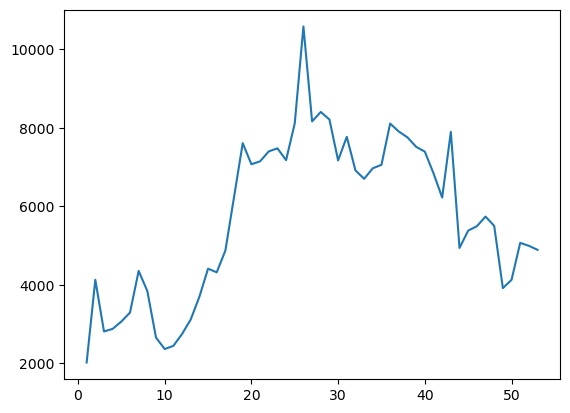

In [1548]:
# agora agrupamos  para saber quantos usuarios acessaram e vemos tudo no grafico
# começamos pela semana:
plotlogs=logs.groupby('semana').agg({'u_p_semana':'mean'}).reset_index()

plt.plot(plotlogs['semana'], plotlogs['u_p_semana'])

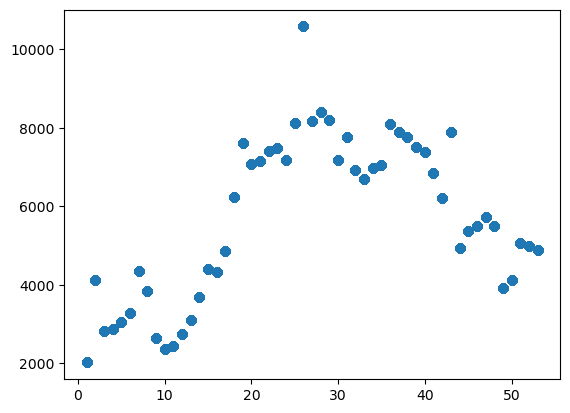

In [1549]:
#isso também fica bom de vizualizar em pontos:
plt.scatter(logs['semana'], logs['u_p_semana'], )

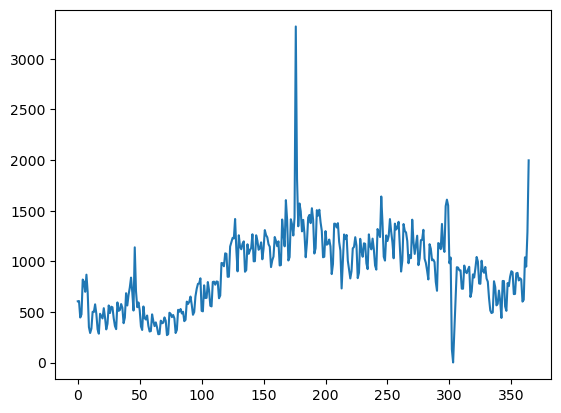

In [1550]:
#como será a tendencia ao longo dos dias? o grafico nos mostrará:
plotlogs=logs.groupby('dia').agg({'u_p_dia':'mean'}).reset_index()
plt.plot(plotlogs['dia'], plotlogs['u_p_dia'], )

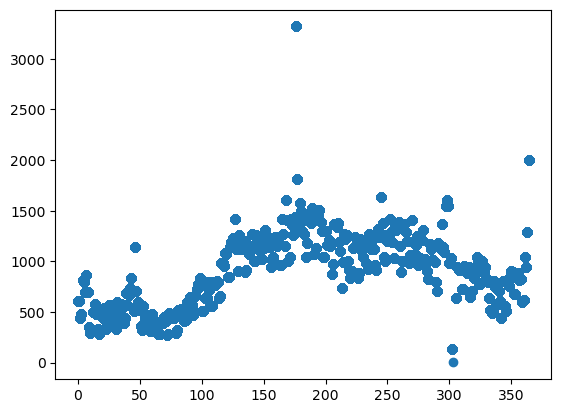

In [1551]:
#novamente o scatter fornece outra perspectiva de visualização:
plt.scatter(logs['dia'], logs['u_p_dia'], )

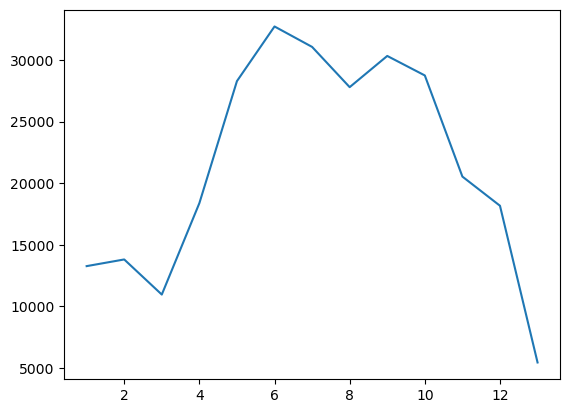

In [1552]:
#por fim como foram os acessos ao longo dos meses?
plotlogs=logs.groupby('mes').agg({'u_p_mes':'mean'}).reset_index()
plt.plot(plotlogs['mes'], plotlogs['u_p_mes'], )

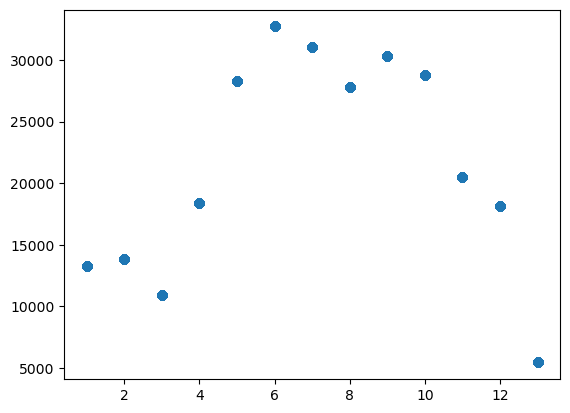

In [1553]:
plt.scatter(logs['mes'], logs['u_p_mes'], )

### Quantas sessões ocorrem por dia?
(um usuário pode realizar várias sessões).  
[sumario](#back)

In [1554]:
logs['s_dia'].mean().round()

1165.0


em média 1165 seções  
*um numero bem proximo da quantidade de usuarios, indicando que os usuarios não costumam retornar à Y.Afisha

<Axes: ylabel='Frequency'>

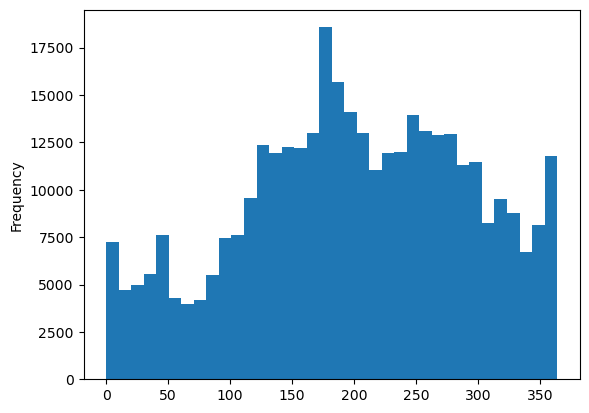

In [1555]:
logs['dia'].plot(kind='hist', bins=36)

### Qual o tamanho de cada sessão? 

In [1556]:
print(logs["tempo''"].mean().round(),
outliers(logs,"tempo''")["tempo''"].mean().round(),
logs["tempo''"].median())

643.0 438.0 300.0


em média 643.0 segundos, ou seja pouco mais de 10 min. Já sem os outliers temos 438 segundos de média, ou seja pouco  mais de 7 min.
entretanto temos uma mediana bem abaixo (300)  o que significa que metade dos usuarios passaram menos de 5min.

Agora vejamos a distribuição do tempo de cada seção:

<Axes: ylabel='Frequency'>

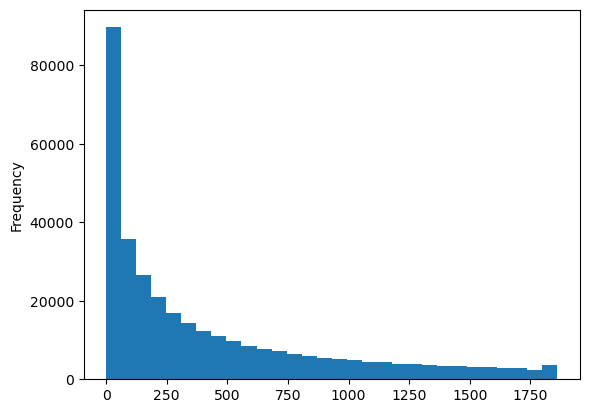

In [1557]:
# para plotar o histograma do tempo da seção é melhor retirar os outliers
outliers(logs,"tempo''")["tempo''"].plot(kind='hist', bins=30)

temos muitas seções com tempo zerado ou quase zerado

### com que frequencia os usuários voltam?
[sumario](#back)

In [1558]:
freq=logs.groupby('Uid').agg({'inicio': 'count'}).reset_index()
freq=freq.rename(columns={'inicio':'qnt'})

print("acessos por cliente: ",freq['qnt'].mean())

print("clientes que retornaram:",freq[freq['qnt']>1]['Uid'].count(),
      " clientes que não retornaram: ",freq[freq['qnt']==1]['Uid'].count(),
      " taxa de retorno: " ,freq[freq['qnt']>1]['Uid'].count()/freq['Uid'].count())

acessos por cliente:  1.5751482453795214
clientes que retornaram: 52128  clientes que não retornaram:  176041  taxa de retorno:  0.2284622363248294


acessos por cliente:  1.5751482453795214  
clientes que retornaram: 52128  
clientes que não retornaram:  176041  
taxa de retorno: aprox. 22%

uma taxa bem baixa, por que será?

## analisando o retorno dos usuarios por coorte:

In [1559]:
logs['tempovidacoorte']=logs['mes']-logs['mes_a1']

In [1560]:
# realizando o coorte pelo primeiro dia de acesso:
coortes = (
    logs.groupby(['mes_a1', 'tempovidacoorte'])
    .agg({'Uid': 'nunique'})
    .reset_index()
) 

,mes_a1,tempovidacoorte,Uid
0,1,0,13260
1,1,1,1020
2,1,2,682
3,1,3,819
4,1,4,897
...,...,...,...
86,11,1,705
87,11,2,122
88,12,0,13137
89,12,1,252


In [1561]:
#identificando o total de usuarios em cada coorte:
contagem_de_usuarios=coortes[coortes['tempovidacoorte']==0].reset_index()
contagem_de_usuarios=contagem_de_usuarios.drop(['tempovidacoorte','index'],axis=1)
contagem_de_usuarios.columns=['mes_a1','usuarios_do_coorte']
contagem_de_usuarios

,mes_a1,usuarios_do_coorte
0,1,13260
1,2,12782
2,3,9581
3,4,16173
4,5,24774
5,6,27341
6,7,24848
7,8,21885
8,9,23611
9,10,21642


In [1562]:
coorte2=pd.merge(coortes,contagem_de_usuarios, on='mes_a1')
#encontrando a porcentagem:
coorte2['retencao']=(coorte2['Uid']/coorte2['usuarios_do_coorte'])*100
coorte2

,mes_a1,tempovidacoorte,Uid,usuarios_do_coorte,retencao
0,1,0,13260,13260,100.000000
1,1,1,1020,13260,7.692308
2,1,2,682,13260,5.143288
3,1,3,819,13260,6.176471
4,1,4,897,13260,6.764706
...,...,...,...,...,...
86,11,1,705,15222,4.631454
87,11,2,122,15222,0.801472
88,12,0,13137,13137,100.000000
89,12,1,252,13137,1.918246


In [1563]:
coorte_acesso_retencao=coorte2.pivot_table(
    index='mes_a1',
    columns='tempovidacoorte',
    values='retencao',
    aggfunc='sum',
)

essa será a porcentagem de retenção, mes a mes, por coorte:

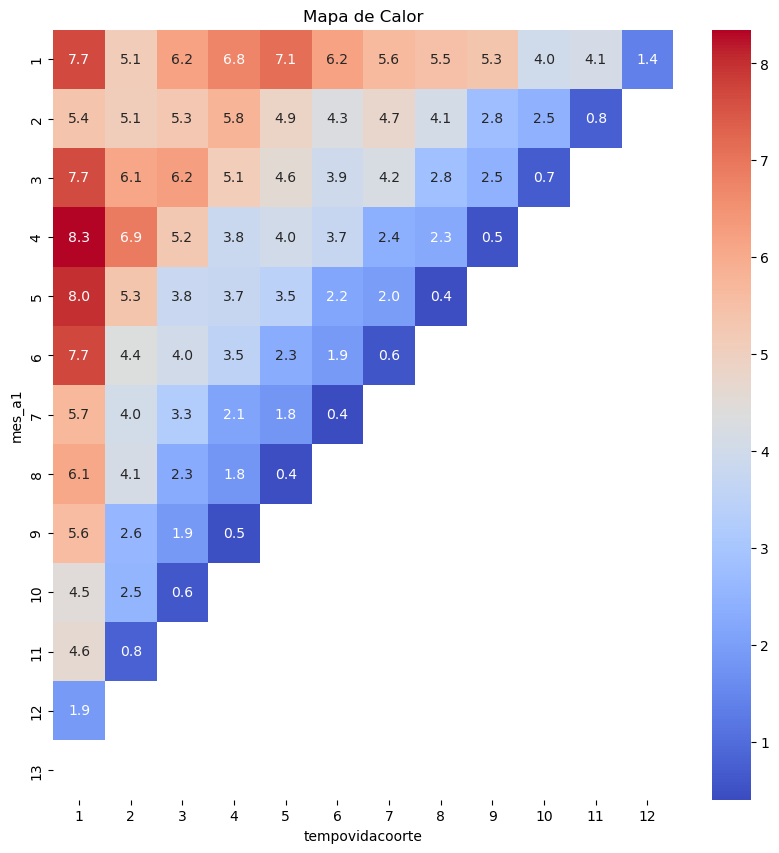

In [1565]:
#tirando a coluna 0 para ficar visualmente mais facil de comparar os meses:
retencaoheatmap=coorte_acesso_retencao.drop( 0 ,axis=1)
#criando o grafico:
plt.figure(figsize=(10, 10))
sn.heatmap(retencaoheatmap, annot=True, cmap='coolwarm', cbar=True, fmt = '.1f')

plt.title('Mapa de Calor')
plt.show()

vejamos também em numeros absolutos:

In [1566]:

coorte_acesso=logs.pivot_table(index='mes_a1', columns='mes',values='Uid',aggfunc='nunique')
coorte_acesso

mes,1,2,3,4,5,6,7,8,9,10,11,12,13
mes_a1,,,,,,,,,,,,,
1,13260.0,1020.0,682.0,819.0,897.0,945.0,821.0,747.0,727.0,709.0,527.0,547.0,184.0
2,NaN,12782.0,688.0,649.0,678.0,740.0,620.0,549.0,606.0,522.0,354.0,315.0,99.0
3,NaN,NaN,9581.0,733.0,585.0,598.0,489.0,440.0,378.0,402.0,272.0,237.0,66.0
4,NaN,NaN,NaN,16173.0,1350.0,1119.0,849.0,621.0,651.0,605.0,385.0,364.0,86.0
5,NaN,NaN,NaN,NaN,24774.0,1978.0,1324.0,944.0,926.0,858.0,533.0,490.0,111.0
6,NaN,NaN,NaN,NaN,NaN,27341.0,2111.0,1195.0,1098.0,964.0,629.0,526.0,157.0
7,NaN,NaN,NaN,NaN,NaN,NaN,24848.0,1413.0,1003.0,809.0,526.0,450.0,101.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21885.0,1328.0,907.0,503.0,399.0,97.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23611.0,1326.0,611.0,443.0,114.0


## primeiras conclusoes parciais do coorte de acessos:

aqui vemos que:  
1 o melhor coorte é o do sexto mês.  
2 o acesso tende a cair muito no segundo mes de cada coorte,  
3 mas se mantem depois disso.  
concluo que muitos acessam para conhecer uma vez e logo vão embora, mas os que ficam acessam com frequencia.  
vamos ver se é verdade:

In [1567]:
freq[freq['qnt']>1]['Uid'].mean()

9.186781145061657e+18

teoria confirmada, dos que acessaram mais de uma vez, tem uma media de 9,1 acessos.

por curiosidade
__qual a taxa de conversão?__
16%

In [1568]:
compras['Uid'].nunique() / logs['Uid'].nunique()


0.16000859012398705

## analise das compras/vendas:

__Vendas__   
    ◦ Quando as pessoas começam a comprar?     
    ◦ Quantos pedidos os clientes fazem durante um determinado período de tempo?  
    ◦ Qual é o volume médio de uma compra?  
    ◦ Quanto dinheiro eles trazem para a empresa (LTV)?  

### Quando as pessoas começam a comprar?  


In [1569]:
compras['conversao'].mean()

18.605353029942023

In [1570]:
conversãopormes=compras.pivot_table(index='acesso1m',values='conversao',aggfunc='mean').reset_index()
conversãopormes

,acesso1m,conversao
0,1,39.407921
1,2,42.712631
2,3,32.757634
3,4,23.859875
4,5,17.177236
5,6,15.077994
6,7,10.426097
7,8,8.932093
8,9,5.873664
9,10,3.593365


__vejamos as compras ao longo do tempo:__

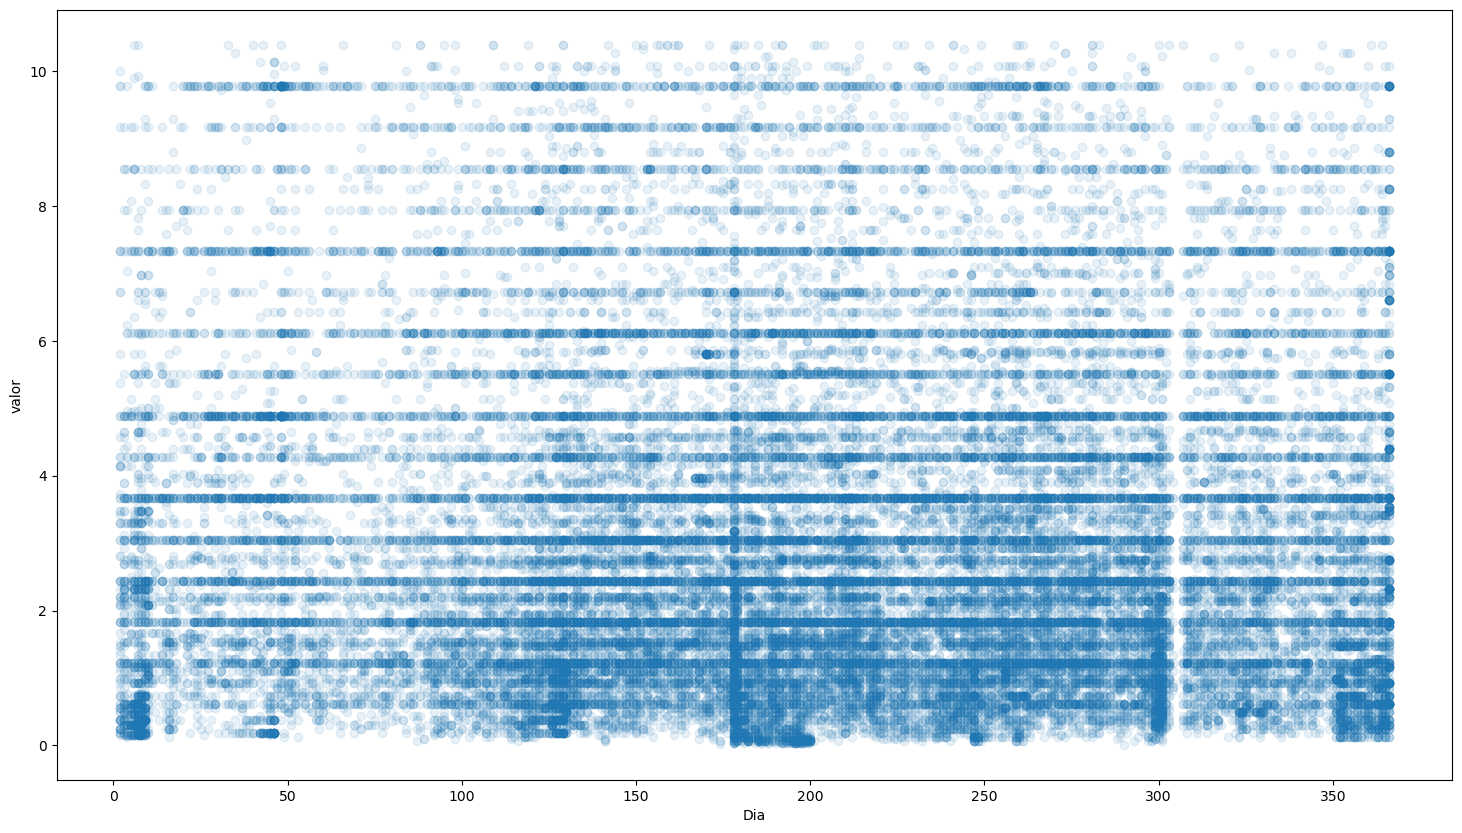

In [1572]:
compras_sem_outliers=outliers(compras, 'compra')
plt.figure(figsize=(18, 10))
plt.xlabel('Dia')
plt.ylabel('valor')
plt.scatter(compras_sem_outliers['dia'], compras_sem_outliers['compra'],alpha=0.1)

__vamos fazer coortes segundo o mes do 1º acesso para ver a quantidade de compradorese a media do tempo de conversão, conforme o passar do tempo__

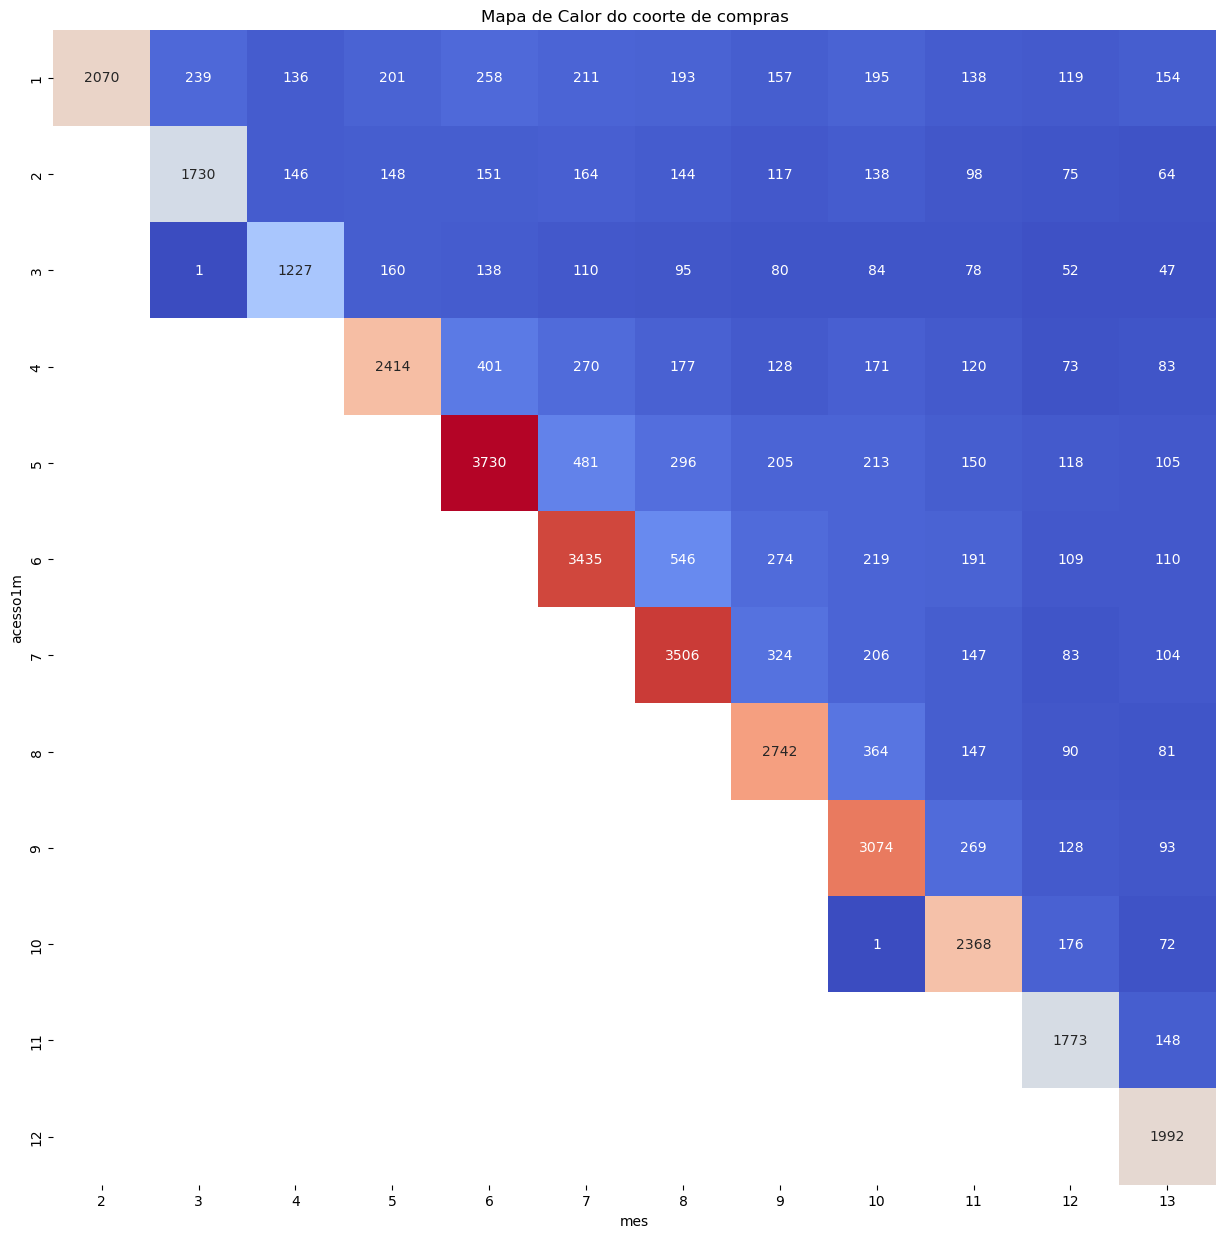

In [1573]:
coorte_compras=compras.pivot_table(index='acesso1m', columns='mes',values='Uid',aggfunc='nunique')
plt.figure(figsize=(15, 15))
sn.heatmap(coorte_compras, annot=True, cmap='coolwarm',cbar=False, fmt = '.0f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()

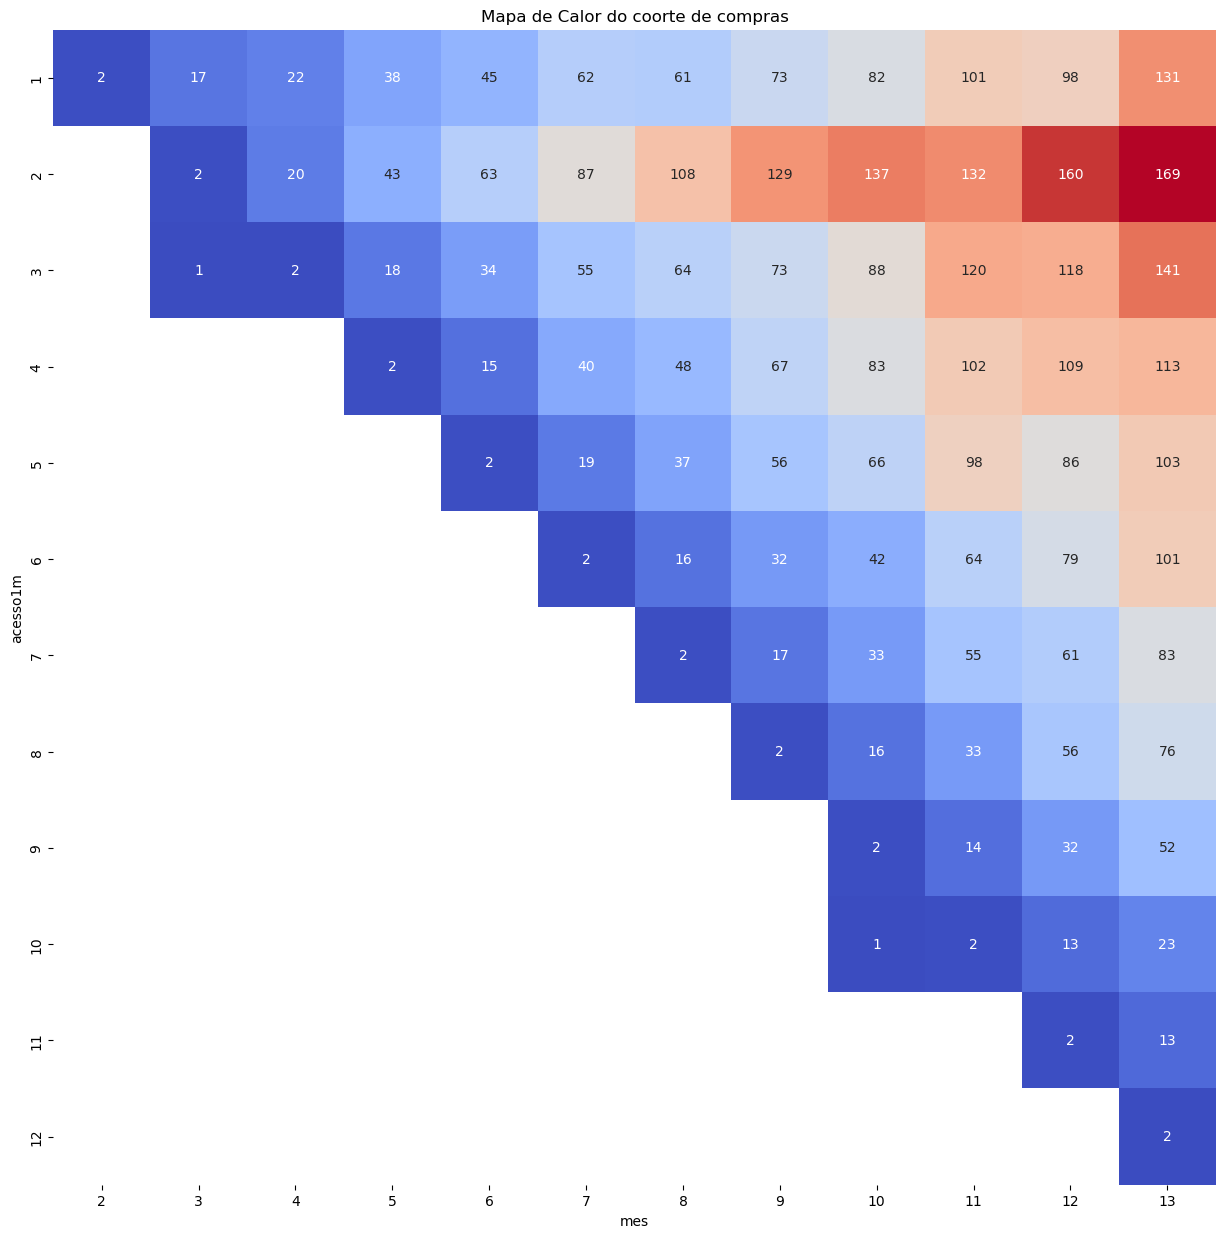

In [1574]:
coorte_compra_conversao=compras.pivot_table(index='acesso1m', columns='mes',values='conversao',aggfunc='mean')
plt.figure(figsize=(15, 15))
sn.heatmap(coorte_compra_conversao, annot=True, cmap='coolwarm',cbar=False, fmt = '.0f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()

### Conclusão parcial sobre quando o usuario começa a comprar
em media os clientes que conheceram o produto nos primeiros meses demoraram mais tempo para comprar alguma coisa, mas isso pode ser em razão de a pesquisa so ter um ano. Certamente se ela continuasse, os outros meses teriam a media aumentada em razão de usuarios que passam a comprar depois de 01/07/2018  
Aimda assim, é necessário concluir que a grande maioria das compras está no primeiro mês do usuario, conforme nos mostra o grafico coorte_compras.
a media de conversão é de: 18 dias para todos os dados, mas é proxima a 40 dias quando levado em conta apenas os usuarios dos dois primeiros meses.
Além disso, não nos esqueçamos que a taxa de conversão é de apenas 16%.

### Qual é o volume médio de uma compra? 
[sumario](#back)

In [1575]:
#valor medio
compras['compra'].mean()

5.004709713287269

<Axes: ylabel='Frequency'>

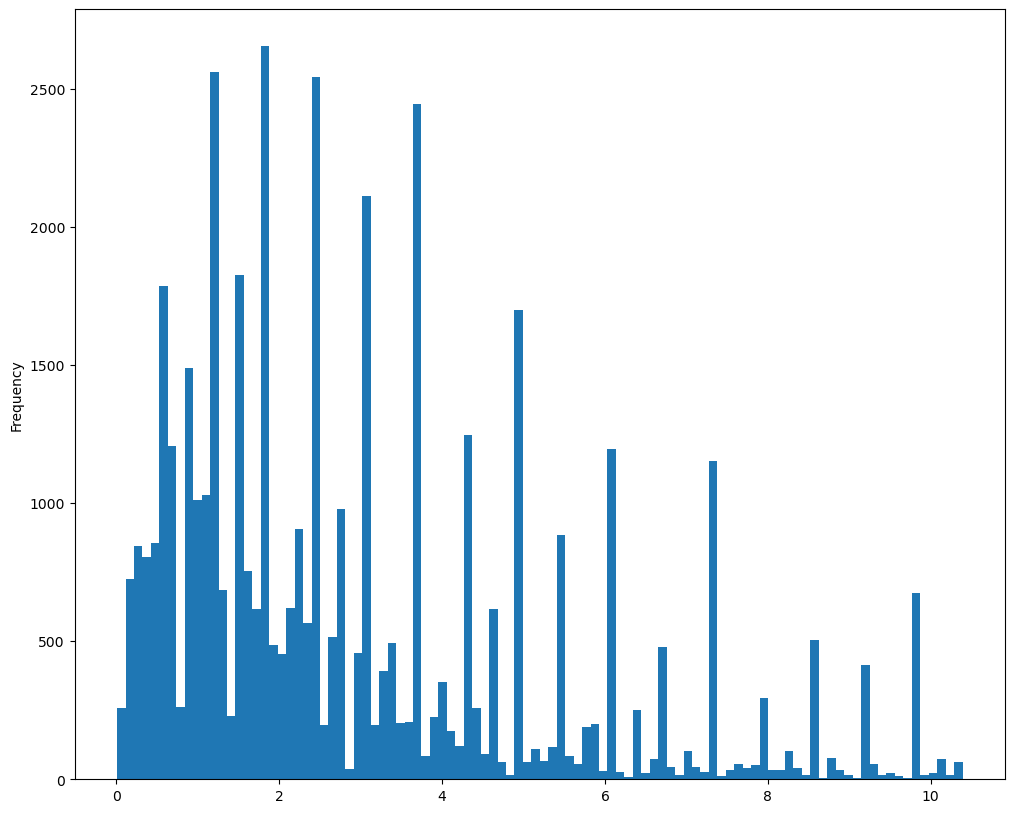

In [1576]:
# analisando a distribuição:
compras_sem_outliers['compra'].plot(kind='hist', bins= 100, figsize=(12,10))    
#interessante! temos valores fixos como opções de compras, temos de diminuir o valor de bins para entendermos melhor

<Axes: ylabel='Frequency'>

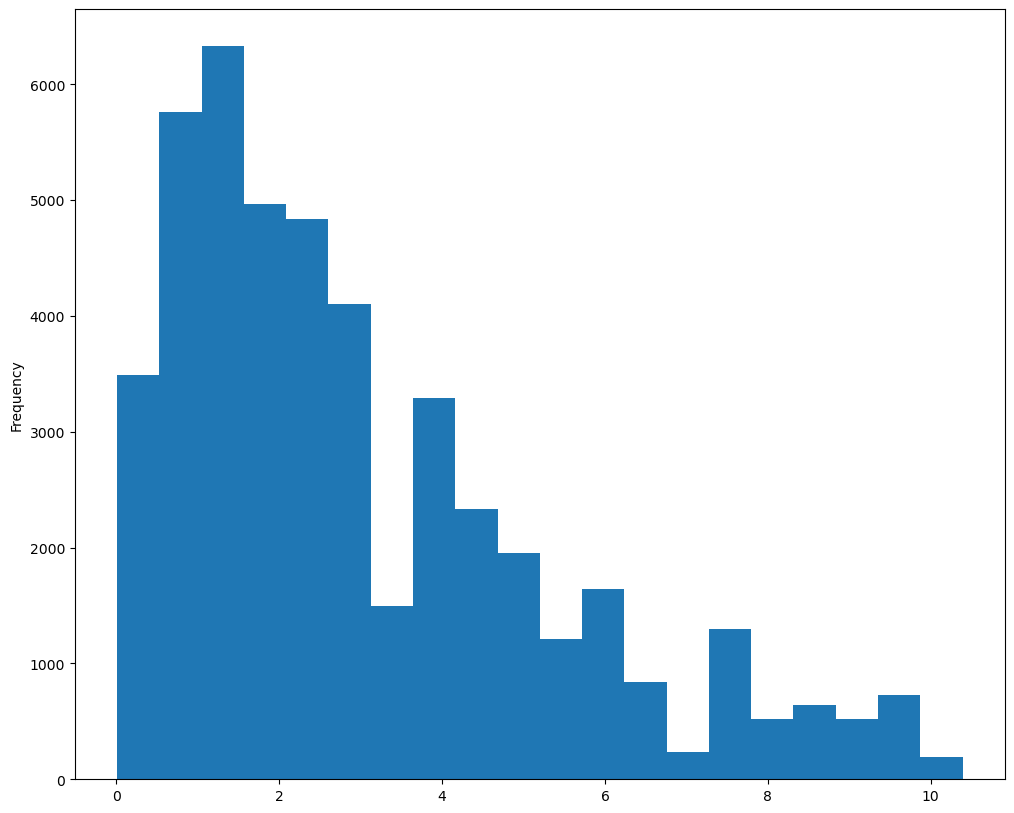

In [1577]:
compras_sem_outliers['compra'].plot(kind='hist', bins= 20, figsize=(12,10))    
#agora sim temos uma noção melhor dos valores de cada compra, muitas abaixo de 3 dolares

Como é o volume de cada venda em cada coorte ?

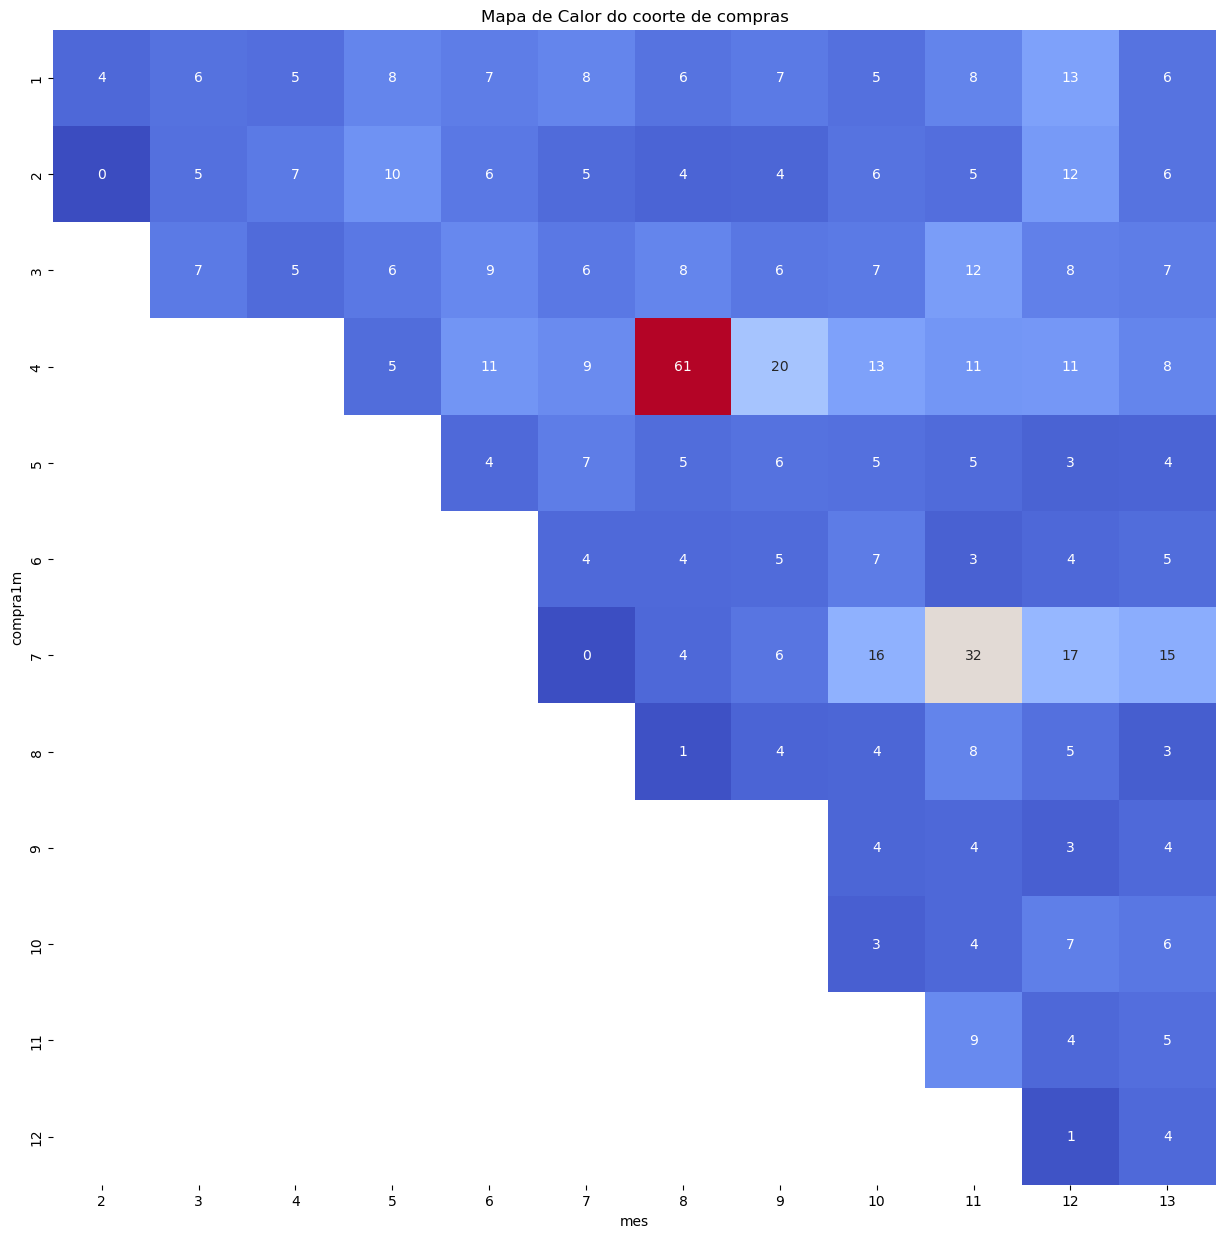

In [1578]:

coorte_compra_media=compras.pivot_table(index='compra1m', columns='mes',values='compra',aggfunc='mean')
plt.figure(figsize=(15, 15))
sn.heatmap(coorte_compra_media, annot=True, cmap='coolwarm',cbar=False, fmt = '.0f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()

temos outliers muito fortes atrapalhando a analise, vamos retirá-los:

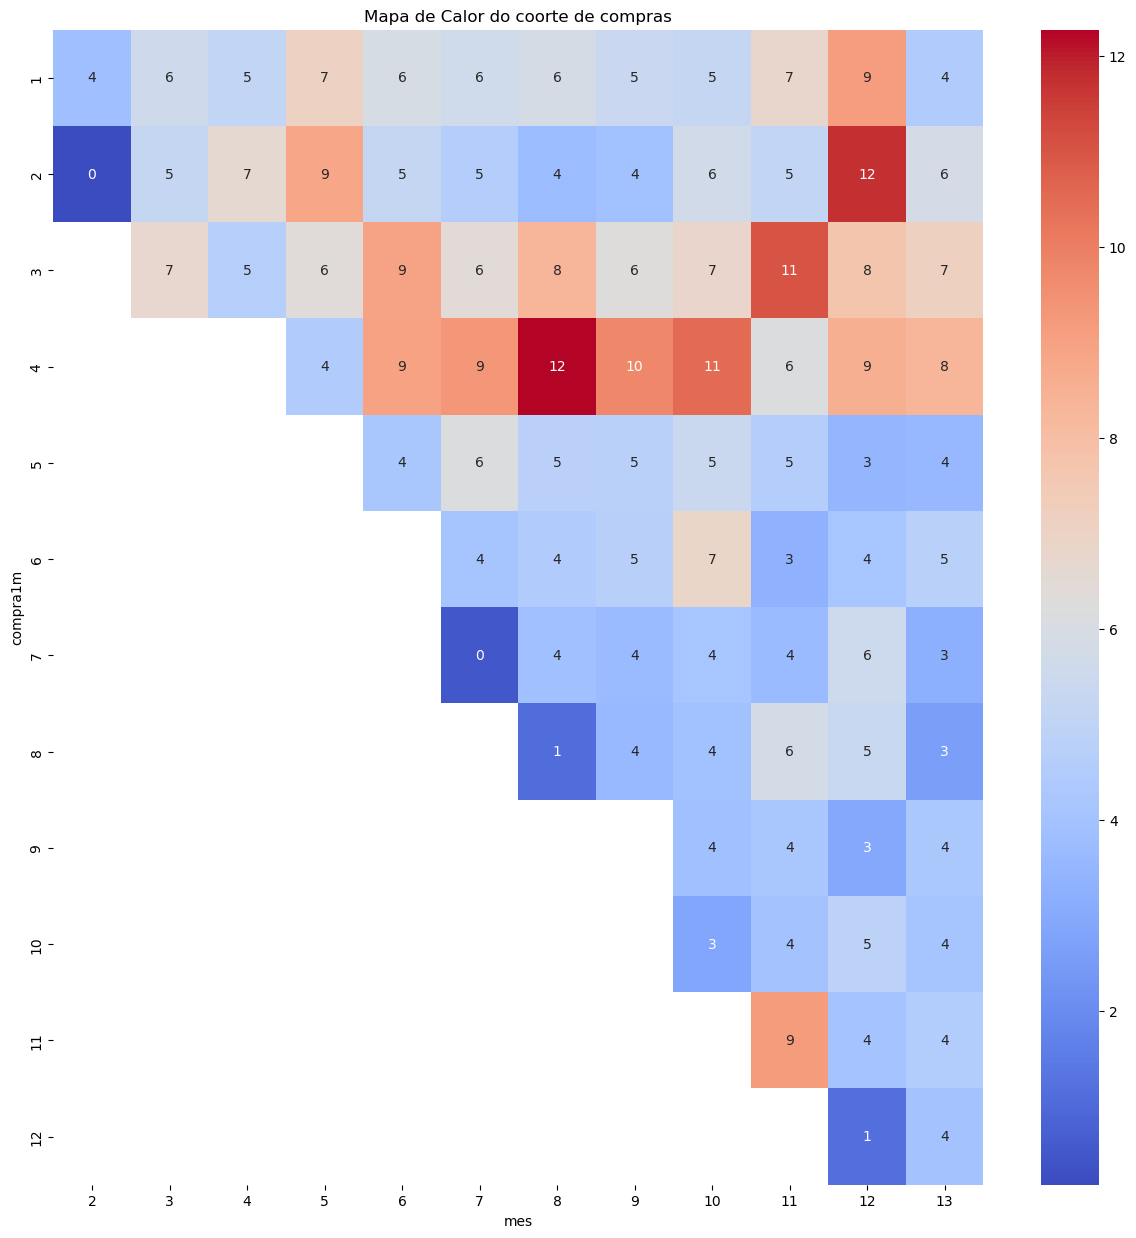

In [1579]:

comprasbaixas=compras[compras['compra'] < 100]
mediacomprasbaixas=comprasbaixas.pivot_table(index='compra1m', columns='mes',values='compra',aggfunc='mean')
plt.figure(figsize=(15, 15))
sn.heatmap(mediacomprasbaixas, annot=True, cmap='coolwarm',cbar=True, fmt = '.0f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()    


### Conclusões parciais sobre o valor de venda:
Média de: $: 5,00   
Além disso grande maioria das compras são em valores abaixo de 10 dolares.   
Percebo haver valores fixos de preferencia nas compras.   
Apesar da media ser de 5, a curva normal atinge o pico logo abaixo de 2 e vai caindo até 10 dolares.   
Os clientes do mes 4 (setembro) são os que em media fazem compras mais elevadas, mesmo se desconsiderarmos os valores atipicos;  
Os de dezembro apresentaram alguns valores atipicos que subiram muito a media, mas sem eles os valores são bem baixos;   
em geral os clientes dos 4 primeiros meses apresentam melhores compras.   

__vejamos as vendas ao longo do tempo__

### Quantos pedidos os clientes fazem durante um determinado período de tempo?

In [1580]:
compraspormes=compras.groupby('mes').agg({'Uid':'count'}).reset_index()
compraspormes.columns=['mes','compras']
compraspormes

,mes,compras
0,2,2410
1,3,2352
2,4,1846
3,5,3590
4,6,5686
5,7,5836
6,8,6201
7,9,4877
8,10,5779
9,11,4732


In [1581]:
compraspormes['compras'].mean()

4197.0

In [1582]:
freq_compra=compras.groupby('Uid').agg({'data': 'count'}).reset_index()
freq_compra=freq_compra.rename(columns={'data':'qnt'})
print("compras por comprador: ",freq_compra['qnt'].mean())

print("clientes que retornaram:",freq_compra[freq_compra['qnt']>1]['Uid'].count(),
      " clientes que não retornaram ",freq_compra[freq_compra['qnt']==1]['Uid'].count(),
      " taxa de retorno " ,freq_compra[freq_compra['qnt']>1]['Uid'].count()/freq_compra['Uid'].count())

compras por comprador:  1.3794954668711825
clientes que retornaram: 6283  clientes que não retornaram  30226  taxa de retorno  0.172094552028267


In [1583]:
freq_compra[freq_compra['qnt']>1]['qnt'].mean()

3.2051567722425593

Text(0.5, 1.0, 'Histograma do Dia do Ano')

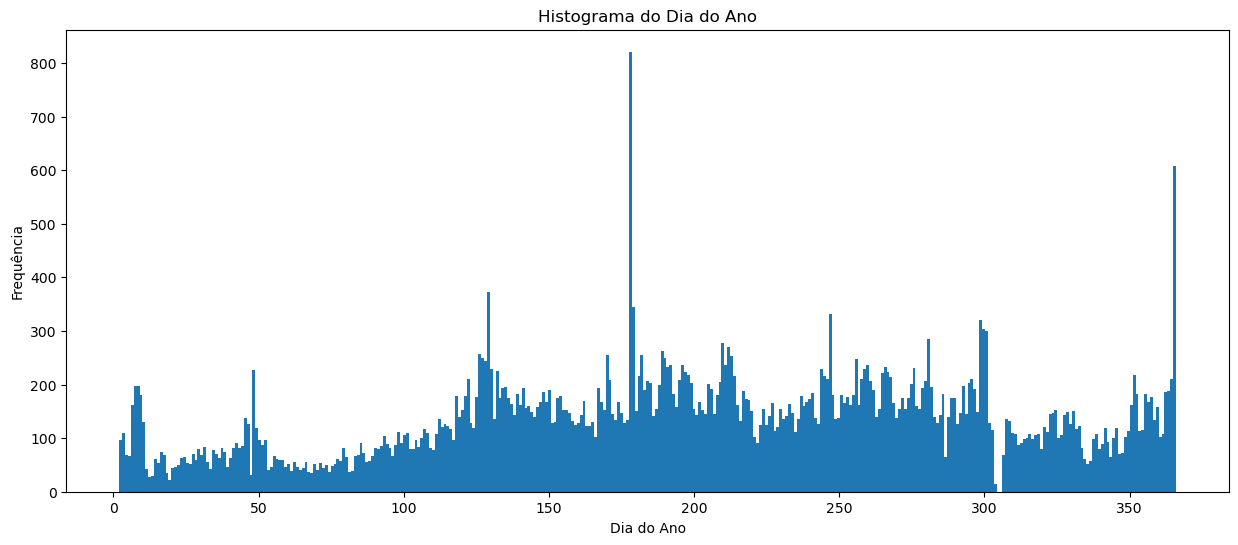

In [1584]:
#agora vamos ver as datas das compras

compras['dia'].plot(kind='hist', bins= 365, figsize=(15,6)) 

plt.xlabel('Dia do Ano')
plt.ylabel('Frequência')
plt.title('Histograma do Dia do Ano')
#temos dias de intensa atividade de compras, talvez dias de promoções?

Text(0.5, 1.0, 'Histograma da semana')

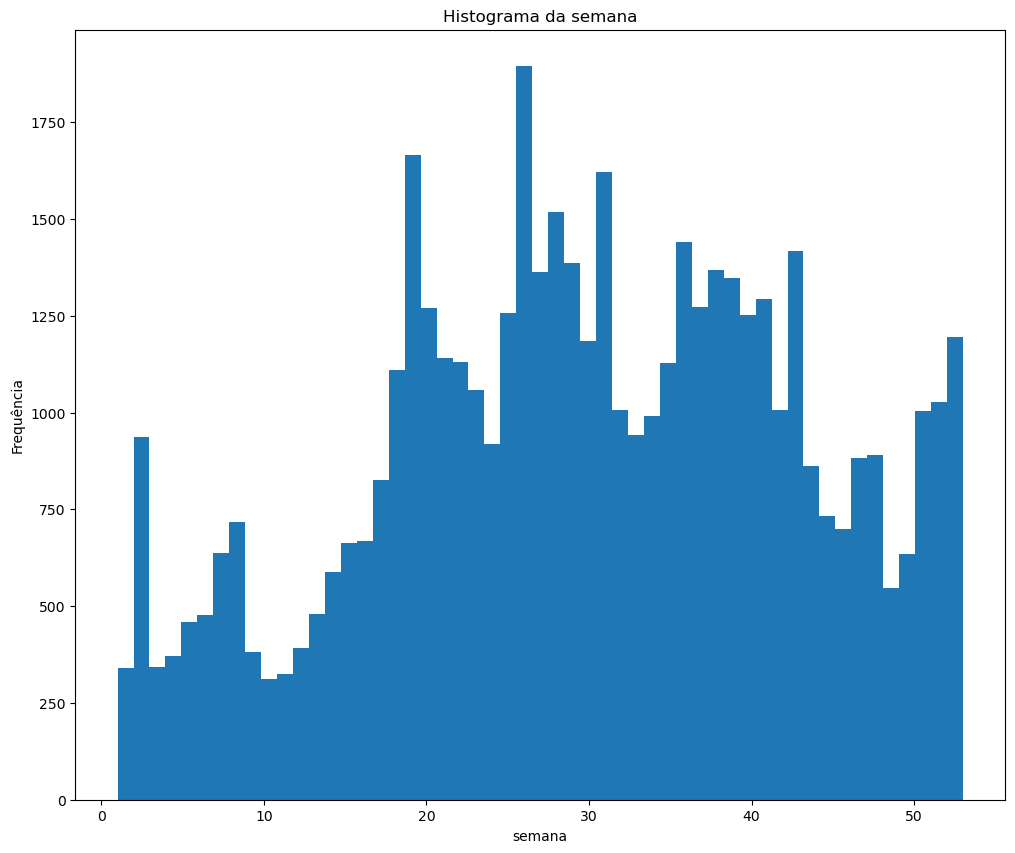

In [1585]:
compras['semana'].plot(kind='hist', bins= 53, figsize=(12,10))    

plt.xlabel('semana')
plt.ylabel('Frequência')
plt.title('Histograma da semana')


__aqui observamos o gradual aumento de vendas nas primeiras semanas, até alcançar o primeiro pico e se estabilizar entre picos e vales semelhantes entre si__

__vejamos um mapa de calor da quantidade de compras__

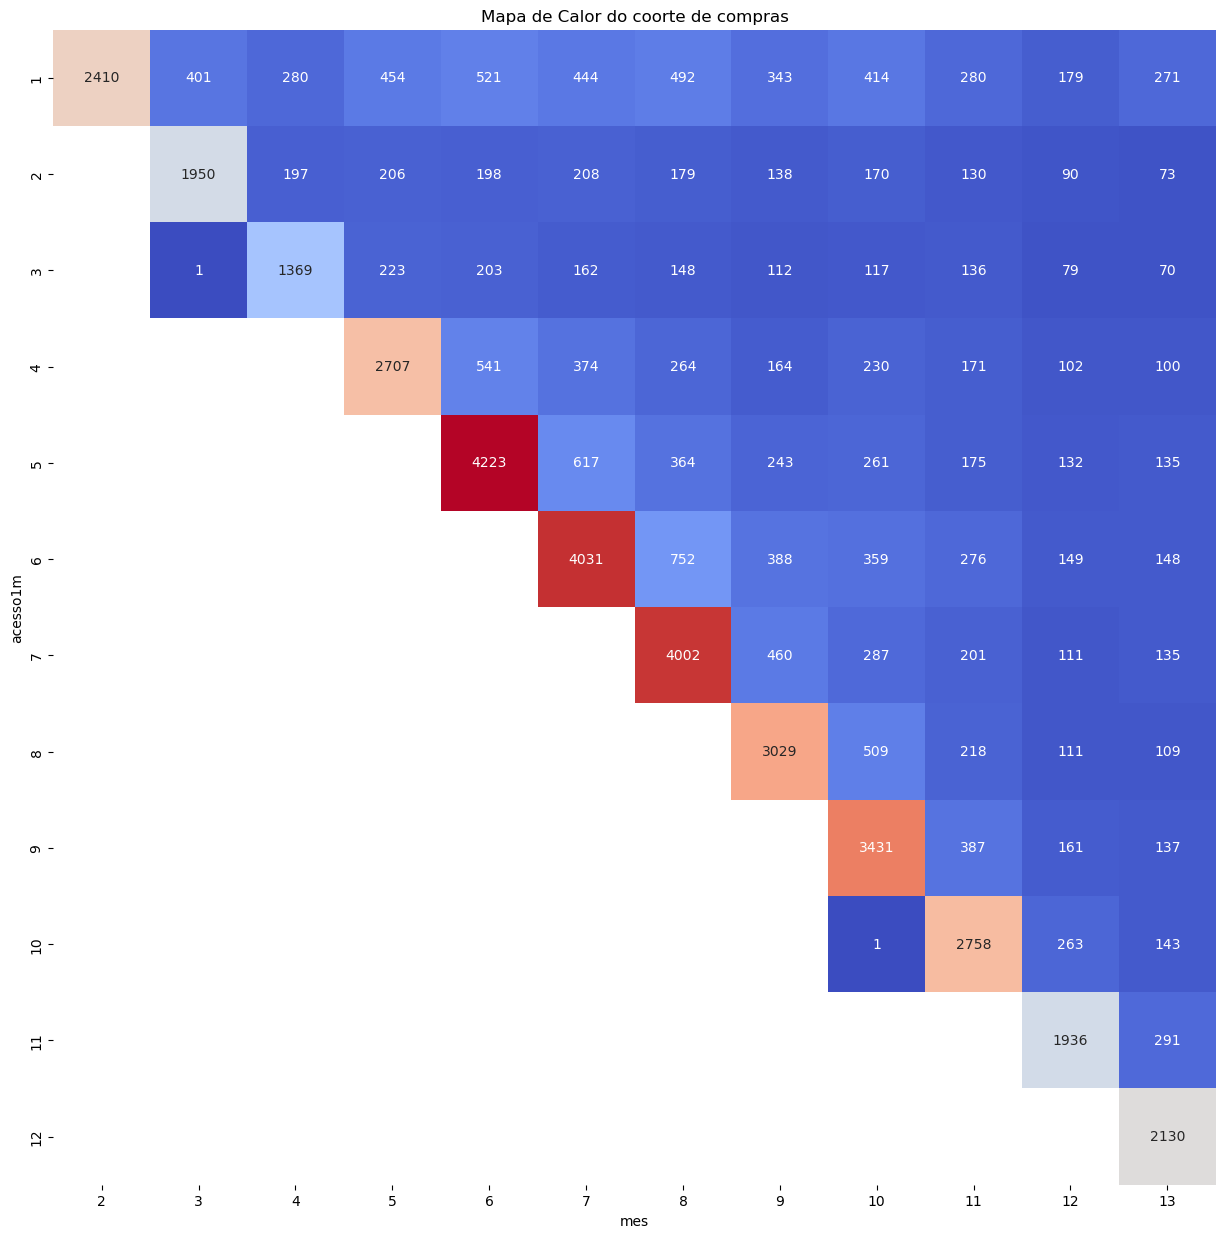

In [1586]:
coorte_compra_acesso_qnt=compras.pivot_table(index='acesso1m', columns='mes',values='compra',aggfunc='count')
plt.figure(figsize=(15, 15))
sn.heatmap(coorte_compra_acesso_qnt, annot=True, cmap='coolwarm',cbar=False, fmt = '.0f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()

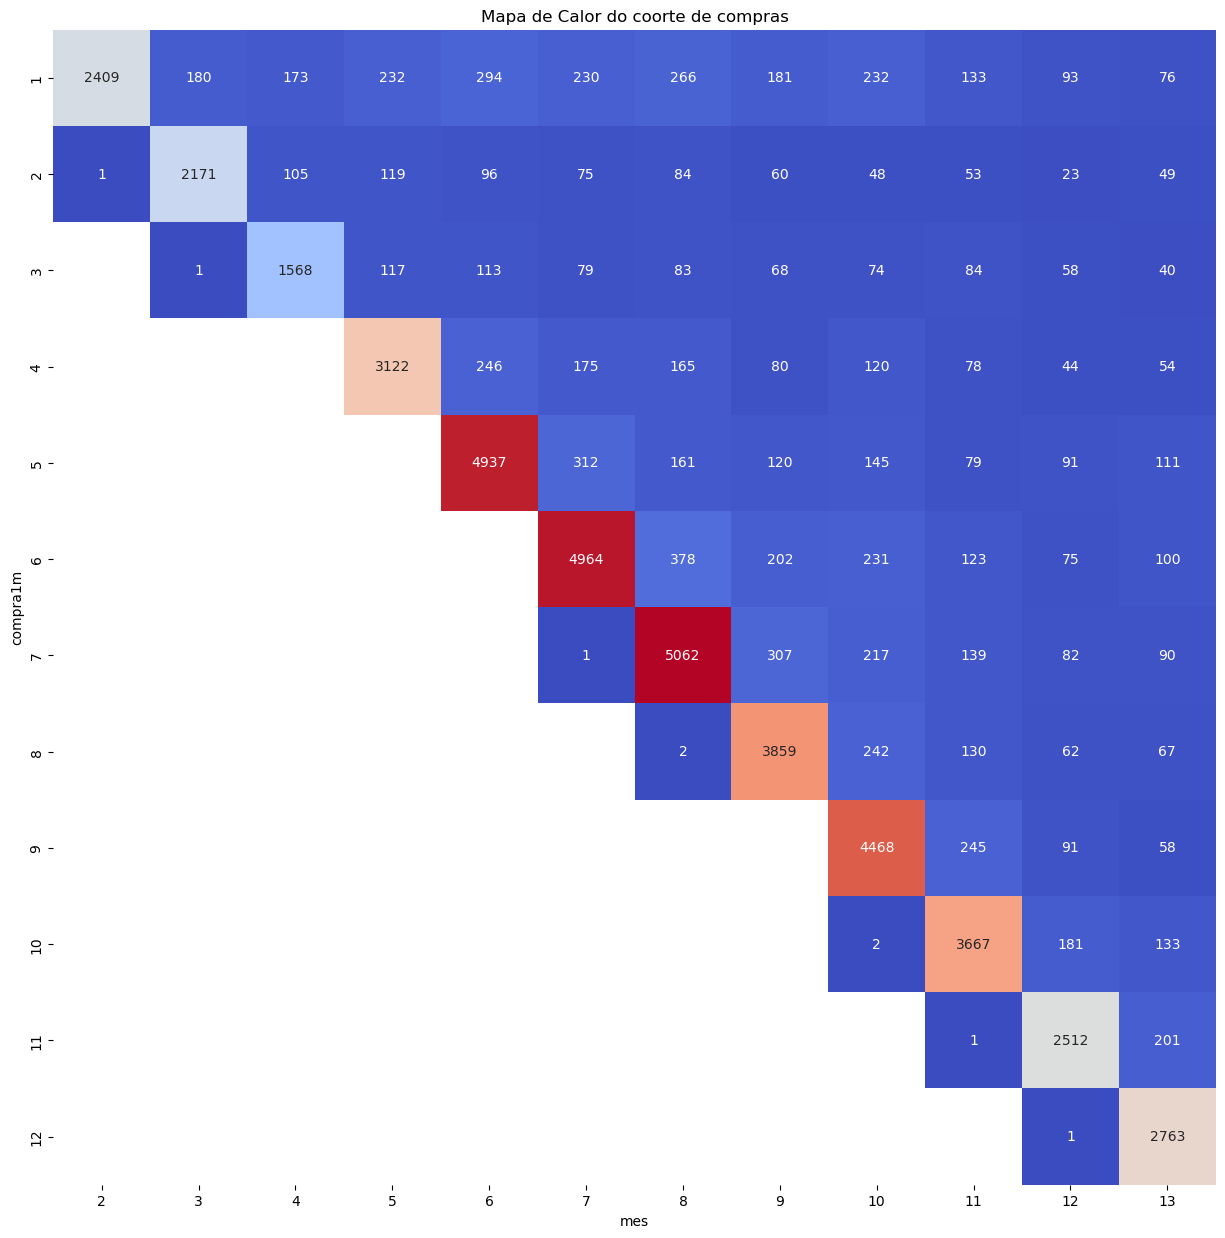

In [1587]:
coorte_compra_qnt=compras.pivot_table(index='compra1m', columns='mes',values='compra',aggfunc='count')
plt.figure(figsize=(15, 15))
sn.heatmap(coorte_compra_qnt, annot=True, cmap='coolwarm',cbar=False, fmt = '.0f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()

In [1588]:
freq_compra=compras.groupby('Uid').agg({'data': 'count'}).reset_index()
freq_compra=freq_compra.rename(columns={'data':'qnt'})
print("compras por comprador: ",freq_compra['qnt'].mean())

print("clientes que retornaram:",freq_compra[freq_compra['qnt']>1]['Uid'].count(),
      " clientes que não retornaram ",freq_compra[freq_compra['qnt']==1]['Uid'].count(),
      " taxa de retorno " ,freq_compra[freq_compra['qnt']>1]['Uid'].count()/freq_compra['Uid'].count())

compras por comprador:  1.3794954668711825
clientes que retornaram: 6283  clientes que não retornaram  30226  taxa de retorno  0.172094552028267


__qualquer angulo que se veja a conclusão é a mesma: o usuário só compra uma vez__

### Conclusões parciais, quantas compras são feitas: 
em media são feitas 3874 compras por mês
a tendencia é que a maioria das compras são no primeiro mes de uso.
do segundo mês em diante se mantem bem mais baixo mas estavel.
cada cliente compra 1,3 vezes, em media.
dos que compram mais de uma vez, a media de compras é 3,2 compras por cliente

a exceção são os primeiros compradores, que se mantem com niveis semelhantes ou até melhores desde o segndo mês.
Alem disso o acumulo de clientes parece fazer diferença, pois os numeros só passam de 5mil compras apos setembro(4º mes), se mantendo relativamente estavel a partir dai.
por fim só 17% dos compradores fazem mais de uma compra.

### Quanto dinheiro os clientes(por coorte) trazem para a empresa (LTV)?  

total: \\$ 252.057,00;
sendo que apenas \\$ 31.977,00 foram de compras de valores abaixo de \\$ 100,00
media por mês= 19389; 
dezembro(7ºmês) é o que mais lucrou: \\$ 36.388,00
junho é o mes do coorte com maior lucro(tambem o de clientes mais antigos) \\$ 40026
10% de toda a receita veio de apenas 5 clientes
alem disso, percebe-se que os clientes que compram mais de uma vez tendem com o passar do tempo a fazer compras maiores, com destaque para os clientes que ingressaram no mes 1 e mes 4 ( junho e setembro)
entretanto se formos ignorar as compras em valores excessivos, encontramos os 3 primeiros coortes como os com as melhores medias de valor de compra.

dinheiro dos clientes(por coorte):  
mes / valor    
1.......40026.05  
2.......17812.11  
3.......13461.87  
4.......33682.56  
5.......27857.69  
6.......24426.72  
7.......31157.85  
8.......14546.82  
9.......15061.29  
10......13770.16  
11......9882.55  
12......10371.53  

In [1589]:
compras['compra'].sum()



252057.2

In [1590]:
comprasbaixas=compras[compras['compra'] > 100]
comprasbaixas['compra'].sum()

31977.730000000003

In [1591]:
comprasmes=compras.groupby('mes')['compra'].sum()
comprasmes.mean()


21004.766666666666

In [1592]:
comprasmes

mes
2      9826.46
3     12521.87
4      8886.03
5     19252.95
6     27989.91
7     28113.23
8     35891.48
9     21108.31
10    27599.04
11    25905.76
12    16914.80
13    18047.36
Name: compra, dtype: float64

In [1593]:
valor_coorte=compras.pivot_table(index='acesso1m',values='compra',aggfunc='sum')
valor_coorte

,compra
acesso1m,
1,40562.41
2,17780.74
3,13267.05
4,35165.35
5,27278.03
6,24728.05
7,31179.32
8,14742.35
9,16395.45


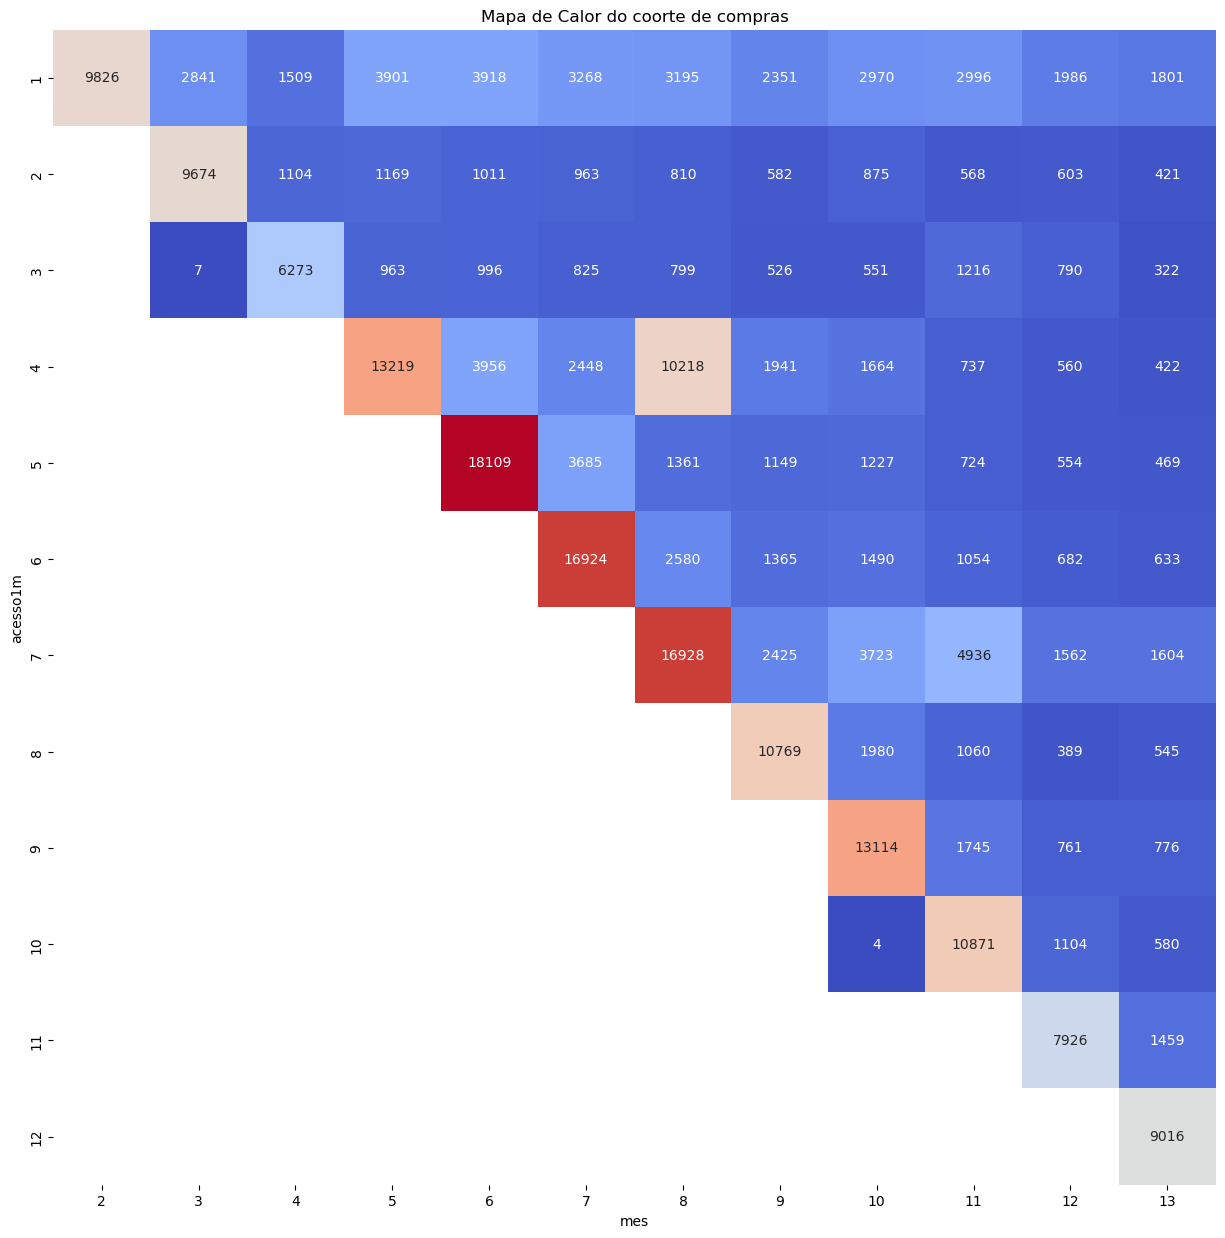

In [1594]:
coorte_compra_valor=compras.pivot_table(index='acesso1m', columns='mes',values='compra',aggfunc='sum')
plt.figure(figsize=(15, 15))
sn.heatmap(coorte_compra_valor, annot=True, cmap='coolwarm',cbar=False, fmt = '.0f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()

In [1595]:
(compras.groupby("Uid").agg({'compra':'sum'}).reset_index()).sort_values(by='compra', ascending=False)


,Uid,compra
11007,5539673724080479777,11810.18
22062,11149926373378902217,10519.46
35656,17999372575896145244,1979.33
13450,6731421022966725351,1450.68
7200,3644482766749211722,1444.29
...,...,...
34121,17244961262408204769,0.03
7120,3609489596216947970,0.03
24713,12497820010814768939,0.03
35411,17884086095866555028,0.03


In [1596]:
compras[(compras['compra'] > 100) & (compras['mes'] == 7)]['Uid'].unique()



array([17999372575896145244,  5915852416327196066, 17855698483359346774,
        9352364483376991844, 17736660553583784503,  5101261381665713092,
       17956827303229825606, 12268483328594815593], dtype=uint64)

In [1597]:
compras[(compras['compra'] > 100) & (compras['mes'] == 7)]['compra'].sum()

2224.79

In [1598]:
milionarios=[17999372575896145244, 10246903932085021612,  5539673724080479777,
        8539015707073391293, 11149926373378902217]
milioes=compras[compras['Uid'].isin(milionarios)]

milioes['compra'].sum()

26086.34

In [1599]:
compras_sem_outliers=outliers(compras, 'compra')

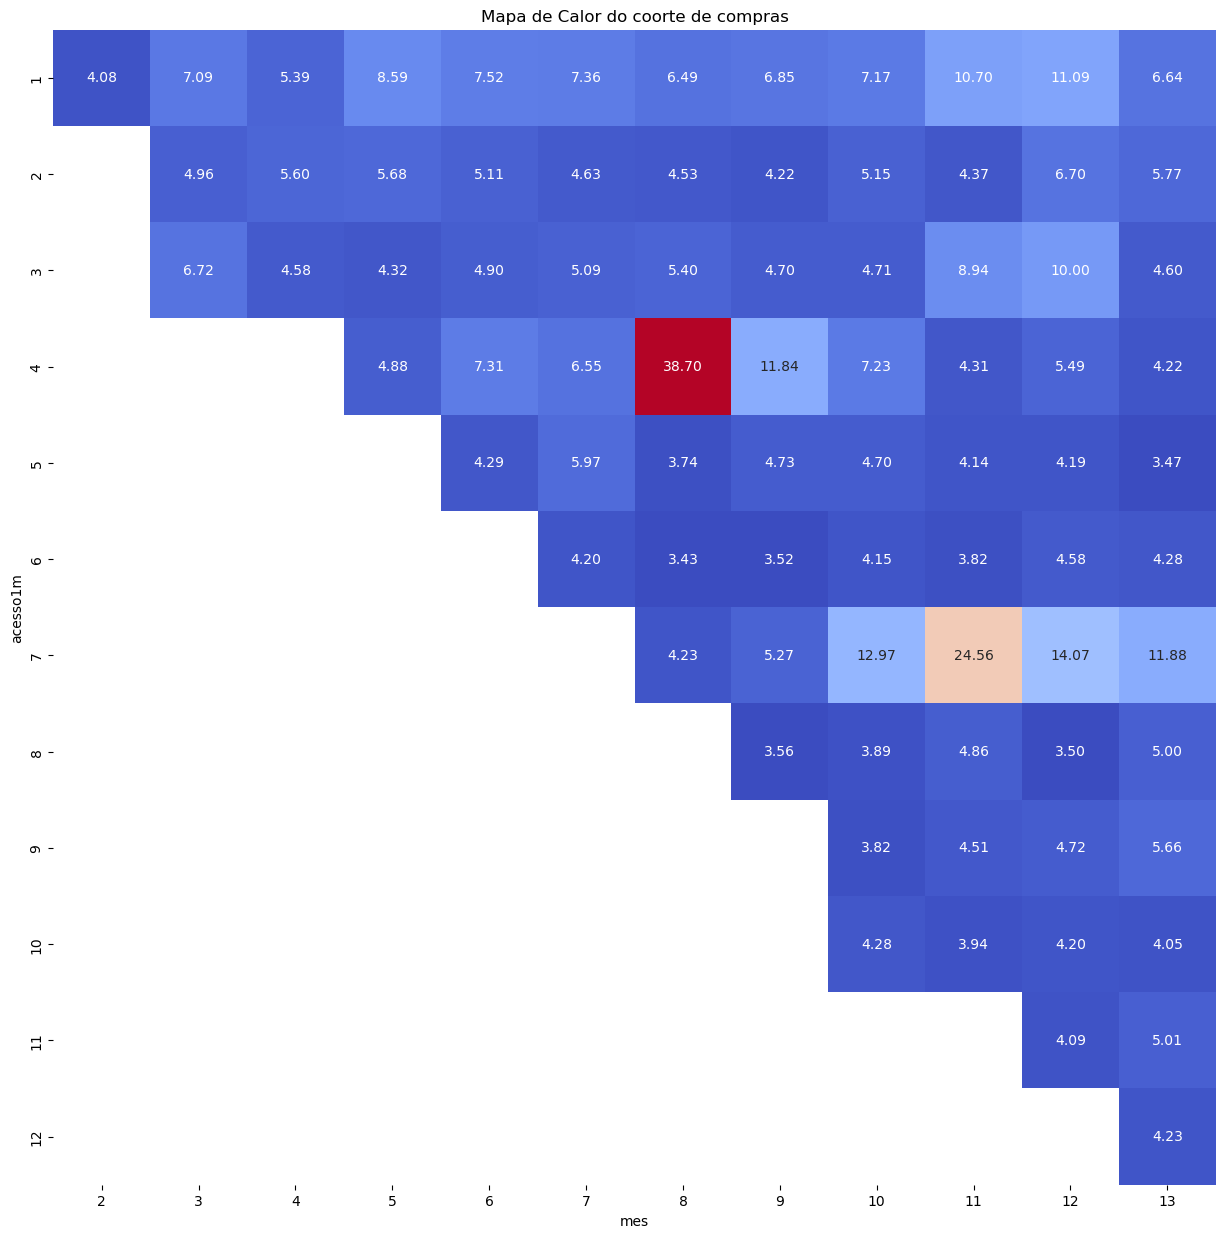

In [1600]:
coorte_compra_media_valor=compras.pivot_table(index='acesso1m', columns='mes',values='compra',aggfunc='mean')
plt.figure(figsize=(15, 15))
sn.heatmap(coorte_compra_media_valor, annot=True, cmap='coolwarm',cbar=False, fmt = '.2f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()

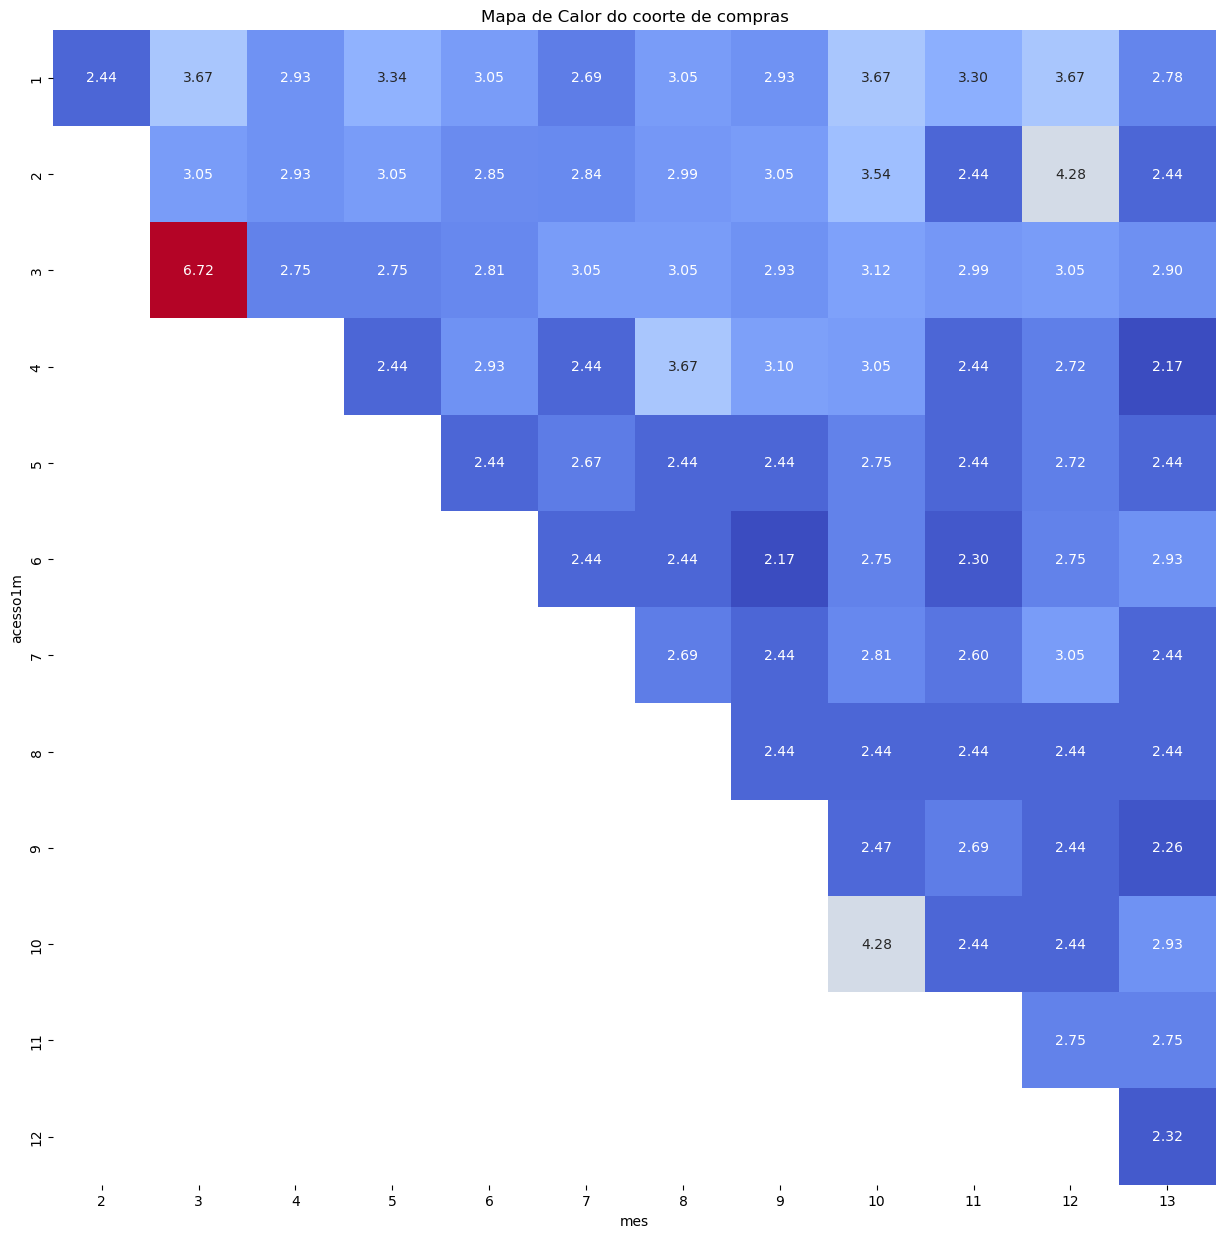

In [1601]:
coorte_compra_media_valor=compras.pivot_table(index='acesso1m', columns='mes',values='compra',aggfunc='median')
plt.figure(figsize=(15, 15))
sn.heatmap(coorte_compra_media_valor, annot=True, cmap='coolwarm',cbar=False, fmt = '.2f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()

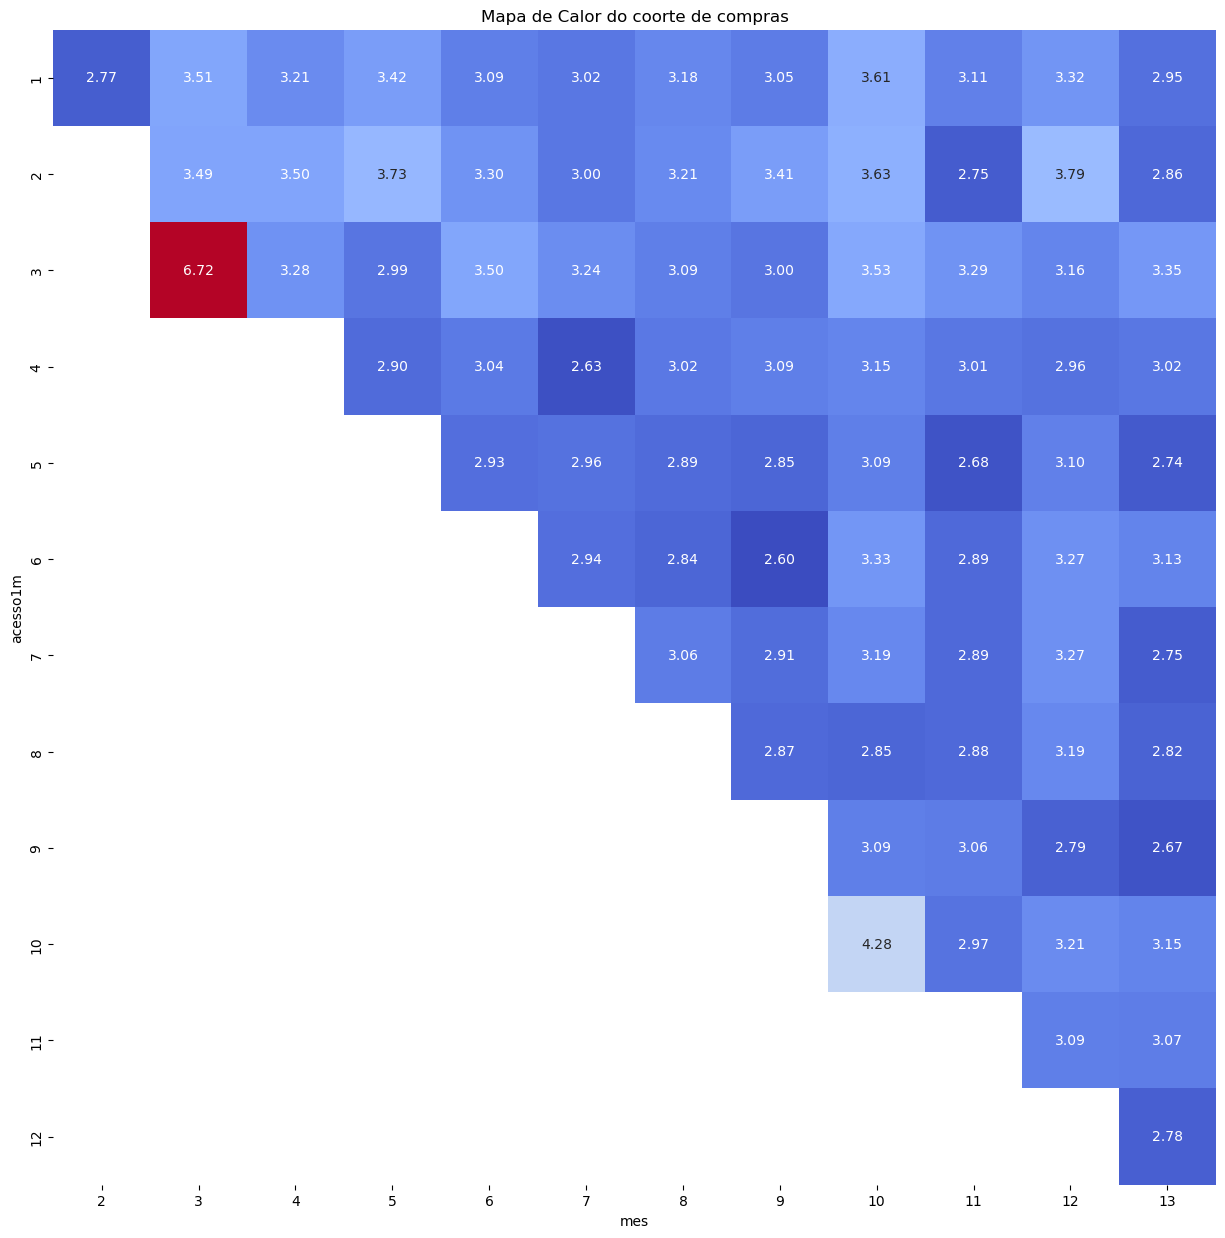

In [1602]:
coorte_compra_media_valor=compras_sem_outliers.pivot_table(index='acesso1m', columns='mes',values='compra',aggfunc='mean')
plt.figure(figsize=(15, 15))
sn.heatmap(coorte_compra_media_valor, annot=True, cmap='coolwarm',cbar=False, fmt = '.2f')

plt.title('Mapa de Calor do coorte de compras')
plt.show()

## Analisando custos

[sumario](#back)

### Quanto dinheiro foi gasto? No total/por origem/ao longo do tempo



#### total: 
$ 329.131,62


In [1604]:
custos['custo'].sum()

329131.62

#### por origem:


In [1605]:
custos_origem=custos.groupby('id_origem')['custo'].sum().reset_index()

Text(0, 0.5, 'valor total')

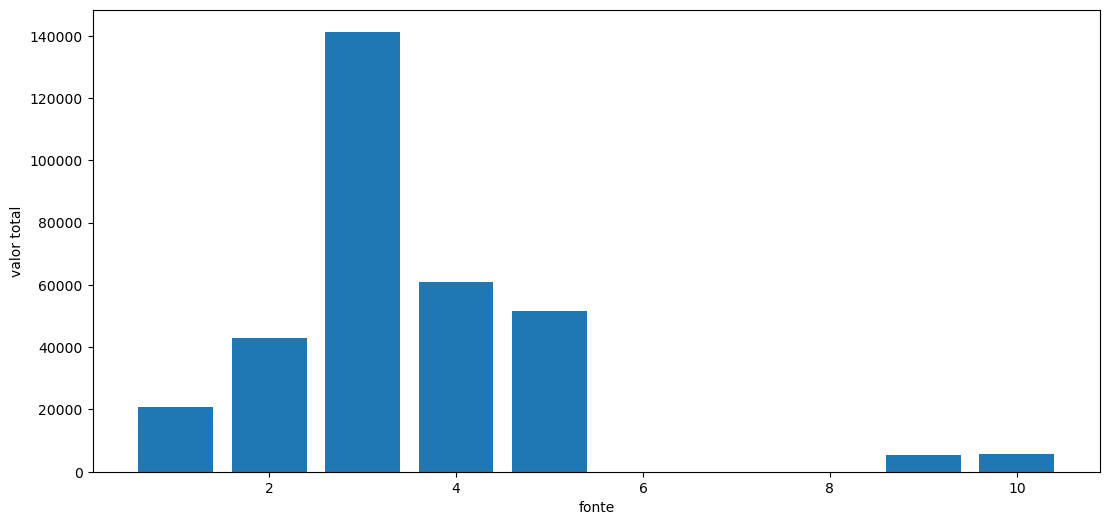

In [1606]:
plt.figure(figsize=(13,6))
plt.bar(custos_origem['id_origem'],custos_origem['custo'])
plt.xlabel('fonte')
plt.ylabel('valor total')


In [1608]:
custos_origem__mes=custos.pivot_table(index=['id_origem','mes'], values='custo',aggfunc='sum')

In [1609]:
id=custos['id_origem'].unique()
id=[ 1,  2,  3,  4,  5,  9, 10]

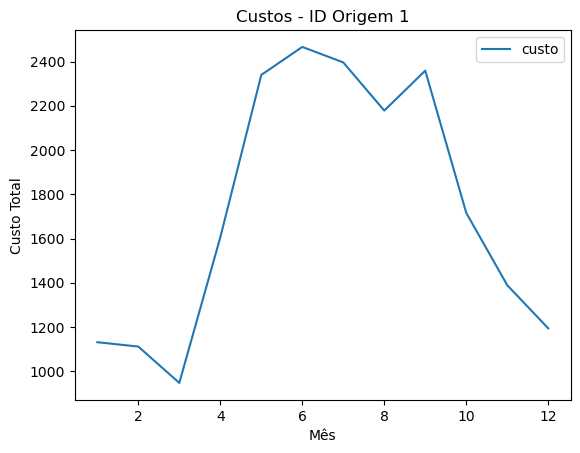

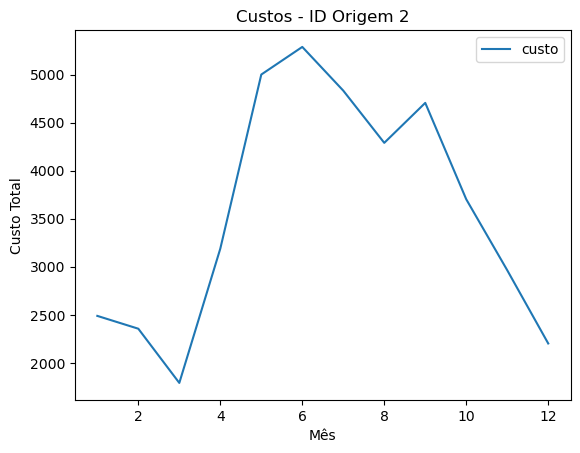

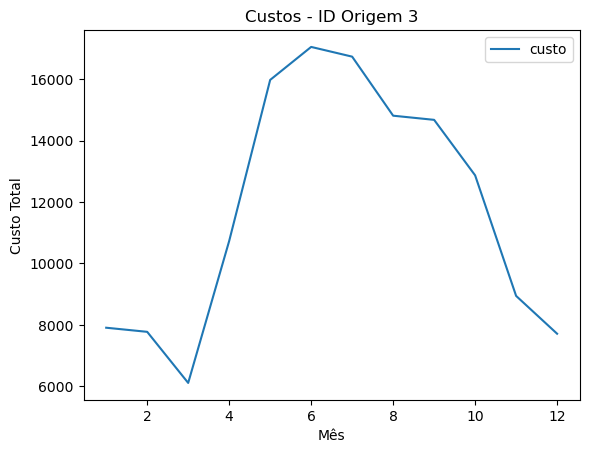

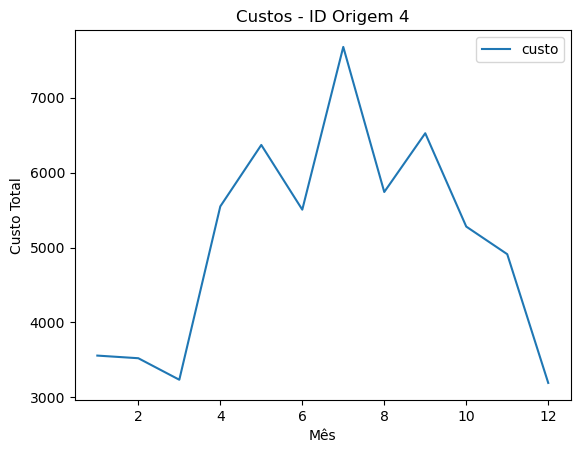

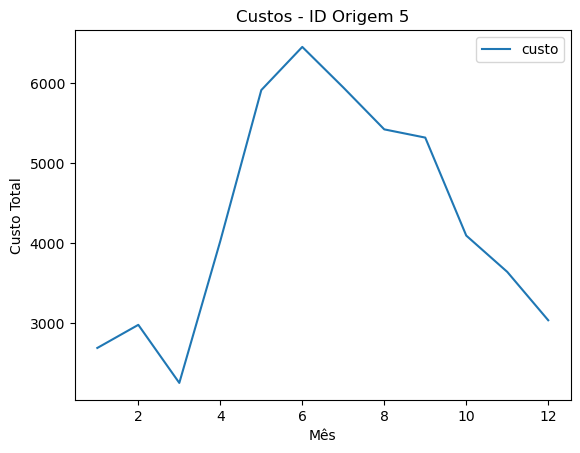

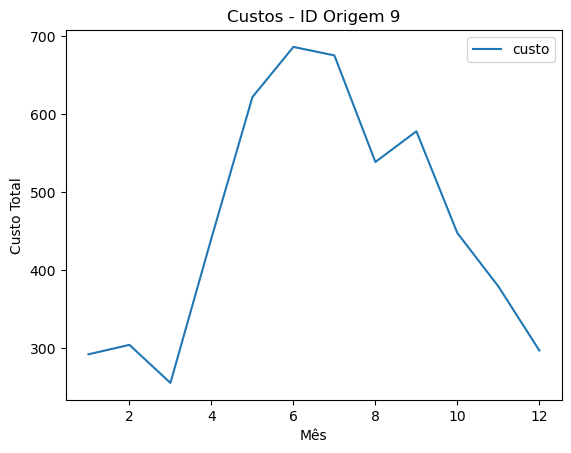

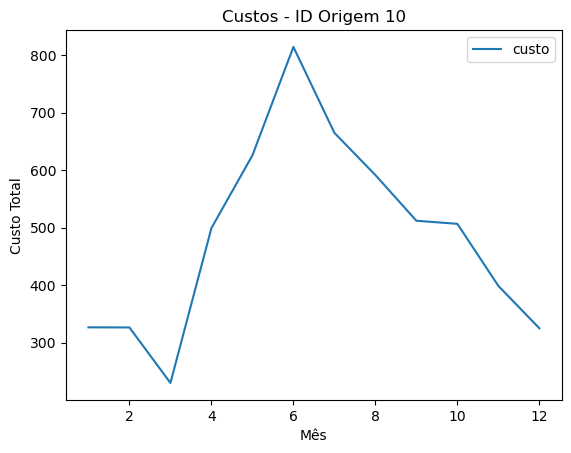

In [1610]:
for num in id:
    a=custos[custos['id_origem']==num]
    plotdf=a.pivot_table(index=['mes'], values='custo',aggfunc='sum')
    
    plotdf.plot()
    plt.title(f'Custos - ID Origem {num}')
    plt.xlabel('Mês')
    plt.ylabel('Custo Total')
    plt.show()


In [1611]:
custos_origem__mes.reset_index()

,id_origem,mes,custo
0,1,1,1131.41
1,1,2,1111.73
2,1,3,947.44
3,1,4,1605.38
4,1,5,2339.28
...,...,...,...
79,10,8,591.64
80,10,9,512.14
81,10,10,506.77
82,10,11,398.78


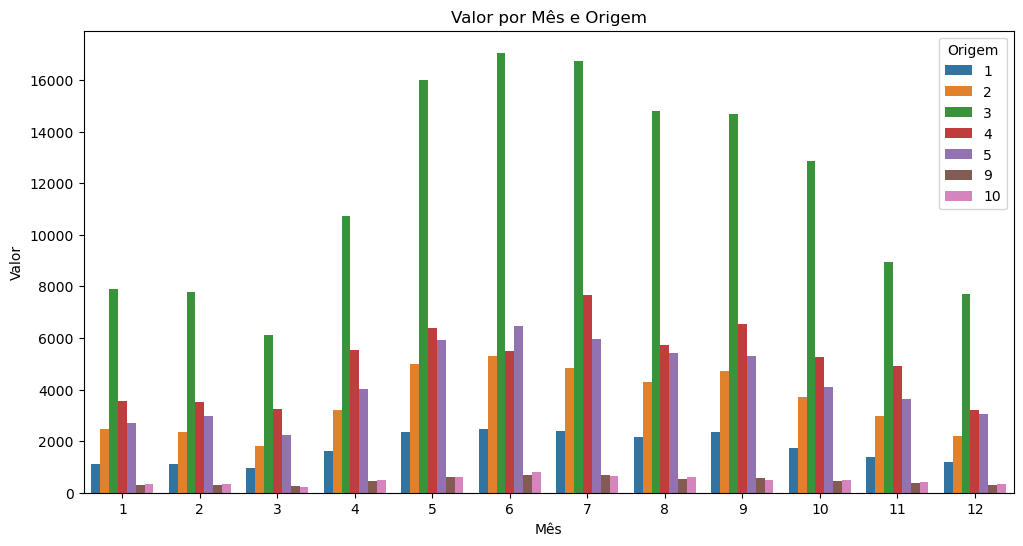

In [1612]:

import seaborn as sns

# Criando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(
    x='mes',
    y='custo',
    hue='id_origem',
    data=custos_origem__mes.reset_index())
plt.title('Valor por Mês e Origem')
plt.xlabel('Mês')
plt.ylabel('Valor')
plt.legend(title='Origem')
plt.show()

#### conclusão parcial gastos por origem:
gastou-se muito na origem 3 $ 141.321;
mas bem pouco nas 1, 9 e 10 (5.500 para cada); 
obs.: não existem origem 6, 7 ou 8.

#### custos ao longo do tempo:


In [1613]:
custosTempo=custossoutliers.groupby('dt').agg({'costs':'sum'}).reset_index()
custosTempom=custossoutliers.groupby('dtm').agg({'costs':'sum'}).reset_index()

In [1614]:
custosTempom

,dtm,costs
0,1,16333.57
1,2,16993.50
2,3,14820.31
3,4,19247.03
4,5,21752.17
5,6,20952.25
6,7,20693.41
7,8,19122.41
8,9,21250.61
9,10,16880.47


Text(0, 0.5, 'valor somado')

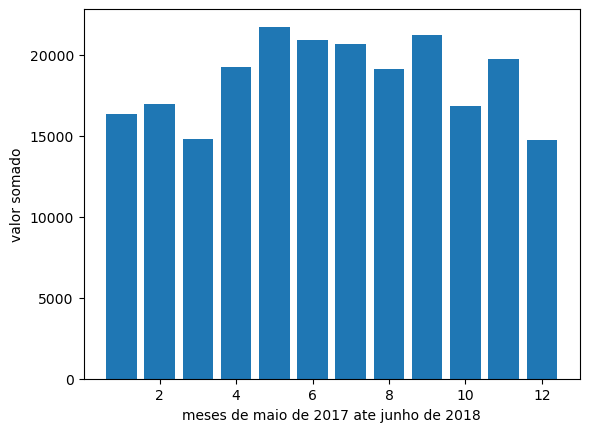

In [1615]:

plt.bar(custosTempom['dtm'],custosTempom['costs'])
plt.xlabel('meses de maio de 2017 ate junho de 2018')
plt.ylabel('valor somado')


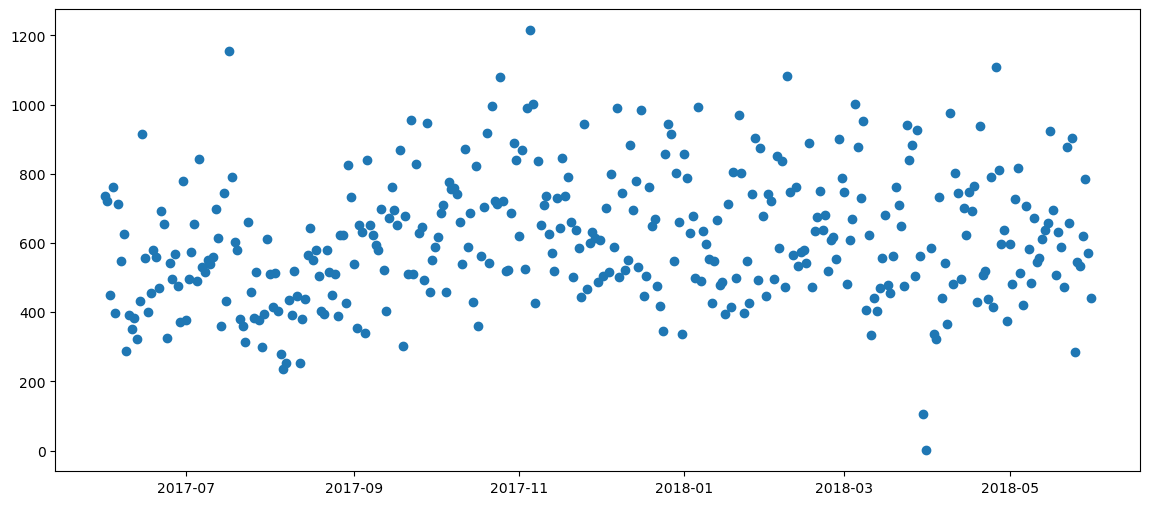

In [1616]:

plt.figure(figsize=(14, 6))
plt.scatter(custosTempo['dt'],custosTempo['costs'])


##### Conclusão parcial dos gastos pelo tempo:
gastou-se sensivelmente menos nos 3 primeiros meses, mas a partir do 4º (quarto) o valor sempre se manteve acima de 18k até o mês 10

### Quanto custou a aquisição de clientes para cada origem?
[sumario](#back)

In [1617]:
custos_origem['custo/usuario']=custos_origem['custo']/logs['Uid'].nunique()
custos_origem['custo/comprador']=custos_origem['custo']/compras['Uid'].nunique()
custos_origem['custo/compra']=custos_origem['custo']/compras['Uid'].count()

custos_origem

,id_origem,custo,custo/usuario,custo/comprador,custo/compra
0,1,20833.27,0.091306,0.570634,0.413654
1,2,42806.04,0.187607,1.172479,0.849933
2,3,141321.63,0.619373,3.870871,2.806005
3,4,61073.60,0.267668,1.672837,1.212644
4,5,51757.10,0.226837,1.417653,1.027661
5,9,5517.49,0.024182,0.151127,0.109552
6,10,5822.49,0.025518,0.159481,0.115608


In [1618]:
print(custos_origem['custo/comprador'].mean().round(3),
custos_origem['custo/comprador'].sum().round(3))

1.288 9.015


In [1619]:
custo_mes_origem=custos.pivot_table(index='mes', columns='id_origem', values='custo', aggfunc='sum').reset_index()

In [1620]:
compradores_por_mes_numero=compras.groupby('mes')['Uid'].nunique().reset_index()

In [1621]:
compradores_por_mes_numero=compradores_por_mes_numero[compradores_por_mes_numero['mes']<13]
compradores_por_mes_numero=compradores_por_mes_numero.rename(columns={'Uid':'comp_mes'})

In [1622]:
custo_mes_origemm=pd.merge(custo_mes_origem,compradores_por_mes_numero, on='mes')
custo_mes_origemm

,mes,1,2,3,4,5,9,10,comp_mes
0,2,1111.73,2355.76,7772.62,3522.78,2977.93,304.21,326.51,2070
1,3,947.44,1791.90,6107.86,3235.57,2252.14,255.40,230.00,1970
2,4,1605.38,3188.59,10732.91,5549.65,4025.10,440.97,499.36,1509
3,5,2339.28,4999.65,15981.65,6369.88,5911.15,622.02,625.90,2923
4,6,2465.90,5286.87,17056.92,5506.13,6450.71,686.41,814.55,4678
5,7,2395.87,4832.17,16740.09,7678.49,5944.55,675.49,665.06,4671
6,8,2178.24,4289.02,14815.81,5741.92,5420.42,538.82,591.64,4957
7,9,2358.63,4704.78,14680.45,6526.30,5317.63,578.20,512.14,4027
8,10,1716.09,3702.02,12872.08,5280.19,4093.37,447.62,506.77,4665
9,11,1389.08,2963.92,8943.50,4911.60,3639.83,379.24,398.78,3706


In [1623]:
custo_mes_origem2=custo_mes_origemm.divide(custo_mes_origemm['comp_mes'], axis=0)
custo_mes_origem2=custo_mes_origem2.drop('mes', axis=1)
custo_mes_origem2

,1,2,3,4,5,9,10,comp_mes
0,0.537068,1.138048,3.754889,1.701826,1.438614,0.146961,0.157734,1.0
1,0.480934,0.909594,3.100437,1.642421,1.143218,0.129645,0.116751,1.0
2,1.063870,2.113048,7.112598,3.677700,2.667396,0.292227,0.330921,1.0
3,0.800301,1.710452,5.467550,2.179227,2.022289,0.212802,0.214129,1.0
4,0.527127,1.130156,3.646199,1.177027,1.378946,0.146732,0.174124,1.0
5,0.512924,1.034504,3.583834,1.643864,1.272650,0.144614,0.142381,1.0
6,0.439427,0.865245,2.988866,1.158346,1.093488,0.108699,0.119354,1.0
7,0.585704,1.168309,3.645505,1.620636,1.320494,0.143581,0.127177,1.0
8,0.367865,0.793573,2.759288,1.131874,0.877464,0.095953,0.108632,1.0
9,0.374819,0.799763,2.413249,1.325310,0.982145,0.102331,0.107604,1.0


In [1624]:
compraspormes=compraspormes[compraspormes['mes']< 13]

In [1625]:
custosporcompras=pd.merge(custo_mes_origem,compraspormes, on='mes')
custosporcompras

,mes,1,2,3,4,5,9,10,compras
0,2,1111.73,2355.76,7772.62,3522.78,2977.93,304.21,326.51,2410
1,3,947.44,1791.90,6107.86,3235.57,2252.14,255.40,230.00,2352
2,4,1605.38,3188.59,10732.91,5549.65,4025.10,440.97,499.36,1846
3,5,2339.28,4999.65,15981.65,6369.88,5911.15,622.02,625.90,3590
4,6,2465.90,5286.87,17056.92,5506.13,6450.71,686.41,814.55,5686
5,7,2395.87,4832.17,16740.09,7678.49,5944.55,675.49,665.06,5836
6,8,2178.24,4289.02,14815.81,5741.92,5420.42,538.82,591.64,6201
7,9,2358.63,4704.78,14680.45,6526.30,5317.63,578.20,512.14,4877
8,10,1716.09,3702.02,12872.08,5280.19,4093.37,447.62,506.77,5779
9,11,1389.08,2963.92,8943.50,4911.60,3639.83,379.24,398.78,4732


#### Conclusão parcial :
em media  \$ 1,2 para cada comprador.  
no total, cada comprados custou \$ 9.  
a seguir a origem e o valor em \$ gasto por origem, para cada comprador:  

0  --  0.570634  
1  --  1.172479  
2  --  3.870871  
3  --  1.672837  
4  --  1.417653  
5  --  0.151127  
6  --  0.159481  

### Os investimentos valeram a pena? (ROI)

[sumario](#back)

#### Calculando LTV

In [1626]:
compras_agrupradas_coorte = compras.groupby(
    ['compra1m', 'mes']
).agg({'compra': 'sum'}).reset_index()
compras_agrupradas_coorte=compras_agrupradas_coorte.rename(columns={'compra': 'receita'})
print(compras_agrupradas_coorte) 

    compra1m  mes   receita
0          1    2   9826.28
1          1    3   1009.75
2          1    4    887.23
3          1    5   1947.60
4          1    6   2104.45
..       ...  ...       ...
80        11   11      9.17
81        11   12  10535.88
82        11   13   1010.99
83        12   12      1.16
84        12   13  12084.08

[85 rows x 3 columns]


In [1627]:
usuarios_por_coorte = compras.groupby('compra1m').agg({'Uid': 'nunique'}).reset_index()
usuarios_por_coorte.columns = ['compra1m', 'n_usuario_coorte']
cp=pd.merge(compras_agrupradas_coorte,usuarios_por_coorte, on='compra1m')
cp

,compra1m,mes,receita,n_usuario_coorte
0,1,2,9826.28,2069
1,1,3,1009.75,2069
2,1,4,887.23,2069
3,1,5,1947.60,2069
4,1,6,2104.45,2069
...,...,...,...,...
80,11,11,9.17,2306
81,11,12,10535.88,2306
82,11,13,1010.99,2306
83,12,12,1.16,2567


In [1628]:
cp['idade']=cp['mes']-cp['compra1m']
cp['ltv']=cp['receita']/cp['n_usuario_coorte']
cp

,compra1m,mes,receita,n_usuario_coorte,idade,ltv
0,1,2,9826.28,2069,1,4.749290
1,1,3,1009.75,2069,2,0.488038
2,1,4,887.23,2069,3,0.428821
3,1,5,1947.60,2069,4,0.941324
4,1,6,2104.45,2069,5,1.017134
...,...,...,...,...,...,...
80,11,11,9.17,2306,0,0.003977
81,11,12,10535.88,2306,1,4.568899
82,11,13,1010.99,2306,2,0.438417
83,12,12,1.16,2567,0,0.000452


#### calculando CAC

In [1629]:
custo_mes=custos.groupby('mes')['custo'].sum().reset_index()

In [1630]:
custo_mes

,mes,custo
0,1,18393.04
1,2,18371.54
2,3,14820.31
3,4,26041.96
4,5,36849.53
5,6,38267.49
6,7,38931.72
7,8,33575.87
8,9,34678.13
9,10,28618.14


In [1631]:
compra_custo=pd.merge(cp,custo_mes, left_on ='compra1m', right_on='mes')
compra_custo['cac'] = compra_custo['custo'] / compra_custo['n_usuario_coorte']
compra_custo

,compra1m,mes_x,receita,n_usuario_coorte,idade,ltv,mes_y,custo,cac
0,1,2,9826.28,2069,1,4.749290,1,18393.04,8.889821
1,1,3,1009.75,2069,2,0.488038,1,18393.04,8.889821
2,1,4,887.23,2069,3,0.428821,1,18393.04,8.889821
3,1,5,1947.60,2069,4,0.941324,1,18393.04,8.889821
4,1,6,2104.45,2069,5,1.017134,1,18393.04,8.889821
...,...,...,...,...,...,...,...,...,...
80,11,11,9.17,2306,0,0.003977,11,22625.95,9.811774
81,11,12,10535.88,2306,1,4.568899,11,22625.95,9.811774
82,11,13,1010.99,2306,2,0.438417,11,22625.95,9.811774
83,12,12,1.16,2567,0,0.000452,12,17957.94,6.995691


#### finalmente calculando o ROMI

In [1632]:
compra_custo['romi'] = compra_custo['ltv'] / compra_custo['cac']
romi = compra_custo.pivot_table(
    index='compra1m', columns='idade', values='romi', aggfunc='mean'
)
romi

idade,0,1,2,3,4,5,6,7,8,9,10,11,12
compra1m,,,,,,,,,,,,,
1,NaN,0.534239,0.054898,0.048237,0.105888,0.114416,0.104134,0.084878,0.065274,0.065738,0.058448,0.065965,0.023968
2,0.000010,0.626262,0.037957,0.066314,0.033527,0.018850,0.016854,0.012856,0.014833,0.014809,0.014690,0.015513,NaN
3,0.000453,0.492667,0.050511,0.068244,0.034206,0.046553,0.028899,0.034072,0.069737,0.030165,0.019266,NaN,NaN
4,NaN,0.588991,0.102988,0.062693,0.388529,0.061221,0.059220,0.033001,0.018867,0.017296,NaN,NaN,NaN
5,NaN,0.585519,0.061090,0.020863,0.018387,0.021233,0.009858,0.008541,0.010780,NaN,NaN,NaN,NaN
6,NaN,0.560799,0.043984,0.024700,0.041492,0.010467,0.008045,0.012426,NaN,NaN,NaN,NaN,NaN
7,0.000013,0.533204,0.047317,0.088708,0.114837,0.035937,0.035106,NaN,NaN,NaN,NaN,NaN,NaN
8,0.000065,0.422449,0.028512,0.031559,0.009818,0.005222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,0.498397,0.029764,0.007713,0.007113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


contudo, precisamos do romi acumulado

In [1633]:
romi_acumulado=romi.cumsum(axis=1).round(4) 
romi_acumulado


idade,0,1,2,3,4,5,6,7,8,9,10,11,12
compra1m,,,,,,,,,,,,,
1,NaN,0.5342,0.5891,0.6374,0.7433,0.8577,0.9618,1.0467,1.1120,1.1777,1.2361,1.3021,1.3261
2,0.0000,0.6263,0.6642,0.7305,0.7641,0.7829,0.7998,0.8126,0.8275,0.8423,0.8570,0.8725,NaN
3,0.0005,0.4931,0.5436,0.6119,0.6461,0.6926,0.7215,0.7556,0.8253,0.8555,0.8748,NaN,NaN
4,NaN,0.5890,0.6920,0.7547,1.1432,1.2044,1.2636,1.2966,1.3155,1.3328,NaN,NaN,NaN
5,NaN,0.5855,0.6466,0.6675,0.6859,0.7071,0.7169,0.7255,0.7363,NaN,NaN,NaN,NaN
6,NaN,0.5608,0.6048,0.6295,0.6710,0.6814,0.6895,0.7019,NaN,NaN,NaN,NaN,NaN
7,0.0000,0.5332,0.5805,0.6692,0.7841,0.8200,0.8551,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0001,0.4225,0.4510,0.4826,0.4924,0.4976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,0.4984,0.5282,0.5359,0.5430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0     0.540825
1     0.579145
2     0.626900
3     0.693033
4     0.742550
5     0.804643
6     0.802283
7     0.842580
8     0.879775
9     0.804100
10    0.922550
11    1.054600

In [1634]:
romi_acumulado.mean(axis=0) 

idade
0     0.000186
1     0.543167
2     0.581209
3     0.633080
4     0.719233
5     0.780463
6     0.858314
7     0.889817
8     0.963320
9     1.052075
10    0.989300
11    1.087300
12    1.326100
dtype: float64

## conclusoes

os coortes apresentam um aumento do ROMI medio muito fraco a partir do quinto mês. Isso indica que o tempo de vida médio e o retorno médio após 1 ano dos clientes do coorte 1 é exceção.  
Assim, é provavel que o romi dos clientes após 1 ano seja muito baixo, até despresível para os calculos.
Diante disto, devo concluir que a eficiencia do marketing não está boa.

no final de 1 ano, a receita total foi de apenas 252 mil, enquanto que a despesa foi de  329 mil
o que gera um resultado de -77 mil no primeiro ano.   
a receita por usuario é 6,9, enquanto o custo por usuario foi de 9,1;   
o ROi é de ~= 0.7658;   
Conforme explicado acima, ainda que se espere que os novos compradores continuem comprando por algum tempo, não se espera muito, visto que a maior parte dos compradores só faz uma compra e se gera muito pouca receita a parrtir do 5 mês.

compras['Uid'].nunique()

custot=custos['custo'].sum()

custo_usuario=custot/36509
custo_usuario

receitat=compras['compra'].sum()
receita_usuario=receitat/36509
receita_usuario

roi=(receita_usuario)/custo_usuario

<Axes: xlabel='idade', ylabel='compra1m'>

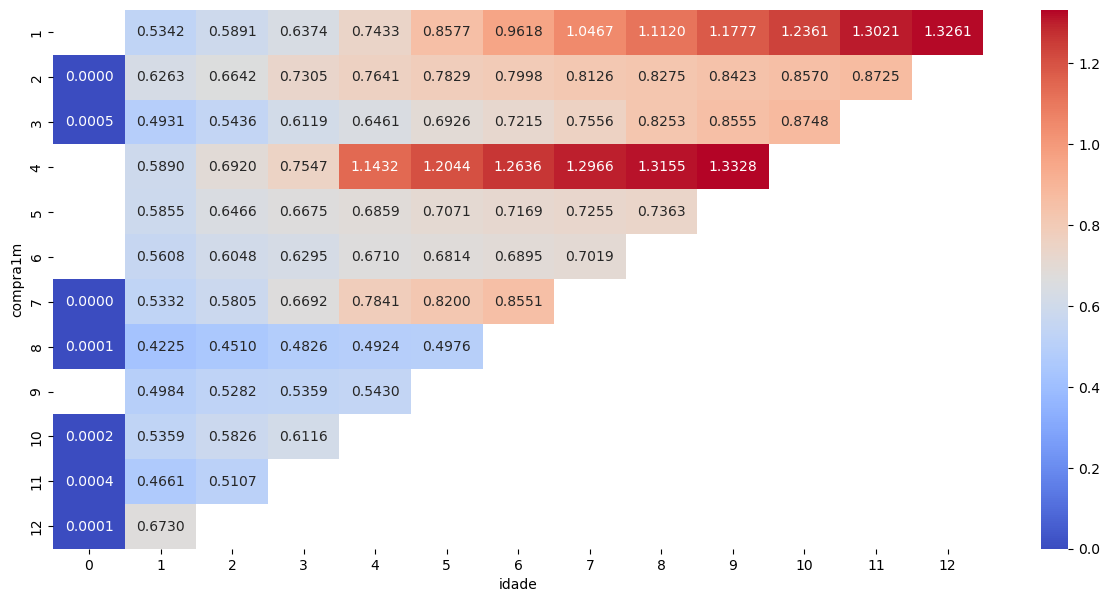

In [1635]:

plt.figure(figsize=(15, 7))
sn.heatmap(romi_acumulado, annot=True, cmap='coolwarm', cbar=True, fmt = '.4f')

para efeitos de marketing, acho melhor analizar o coortes pelo dia de primeiro acesso, não da primeira compra então vou criar outra tabela para isso, usando o codigo anterior como modelo (inclusive usando as mesmas variaveis de antes).

In [1636]:
compras_agrupradas_coorte = compras.groupby(
    ['acesso1m', 'mes']
).agg({'compra': 'sum'}).reset_index()
compras_agrupradas_coorte=compras_agrupradas_coorte.rename(columns={'compra': 'receita'})
usuarios_por_coorte = compras.groupby('acesso1m').agg({'Uid': 'nunique'}).reset_index()
usuarios_por_coorte.columns = ['acesso1m', 'n_usuario_coorte']
cp=pd.merge(compras_agrupradas_coorte,usuarios_por_coorte, on='acesso1m')

cp['idade']=cp['mes']-cp['acesso1m']
cp['ltv']=cp['receita']/cp['n_usuario_coorte']

custo_mes=custos.groupby('mes')['custo'].sum().reset_index()

compra_custo=pd.merge(cp,custo_mes, left_on ='acesso1m', right_on='mes')

In [1637]:
compra_custo

,acesso1m,mes_x,receita,n_usuario_coorte,idade,ltv,mes_y,custo
0,1,2,9826.46,2988,1,3.288641,1,18393.04
1,1,3,2841.30,2988,2,0.950904,1,18393.04
2,1,4,1509.07,2988,3,0.505044,1,18393.04
3,1,5,3901.29,2988,4,1.305653,1,18393.04
4,1,6,3917.89,2988,5,1.311208,1,18393.04
...,...,...,...,...,...,...,...,...
75,10,12,1103.56,2531,2,0.436017,10,28618.14
76,10,13,579.63,2531,3,0.229012,10,28618.14
77,11,12,7926.11,1879,1,4.218260,11,22625.95
78,11,13,1458.57,1879,2,0.776248,11,22625.95


<Axes: xlabel='idade', ylabel='acesso1m'>

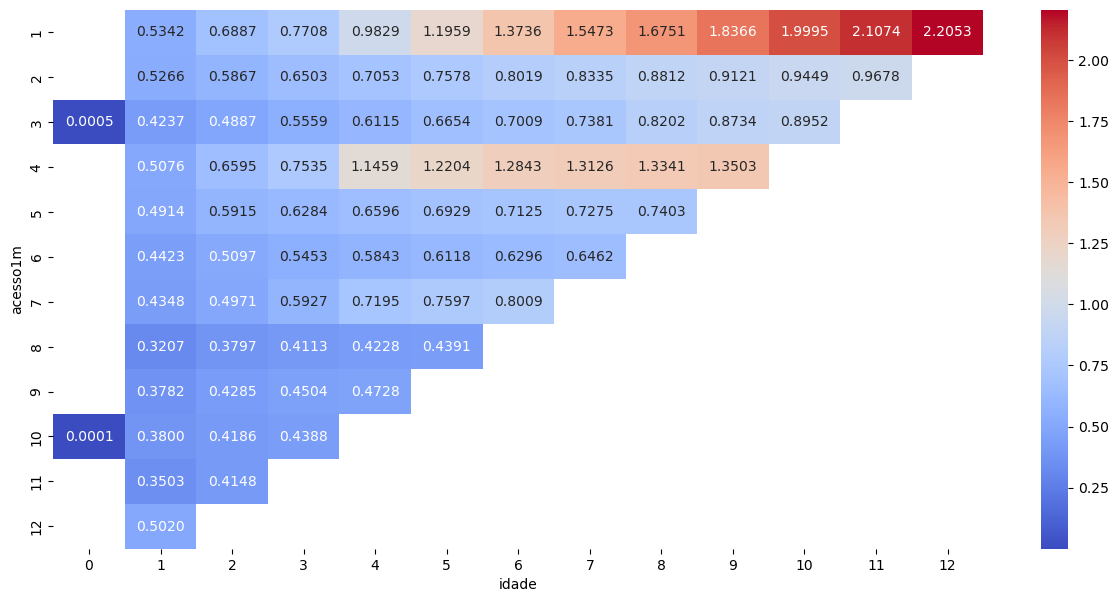

In [1638]:

compra_custo['cac'] = compra_custo['custo'] / compra_custo['n_usuario_coorte']
compra_custo
compra_custo['romi'] = compra_custo['ltv'] / compra_custo['cac']
romi = compra_custo.pivot_table(
    index='acesso1m', columns='idade', values='romi', aggfunc='mean'
)

romi_acumulado2=romi.cumsum(axis=1).round(4)
plt.figure(figsize=(15, 7))
sn.heatmap(romi_acumulado2, annot=True, cmap='coolwarm', cbar=True, fmt = '.4f')

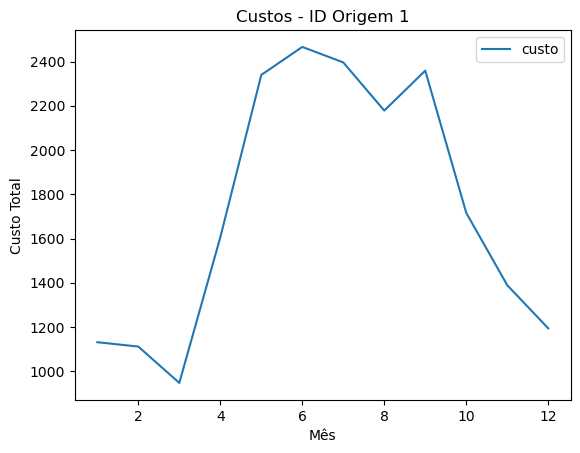

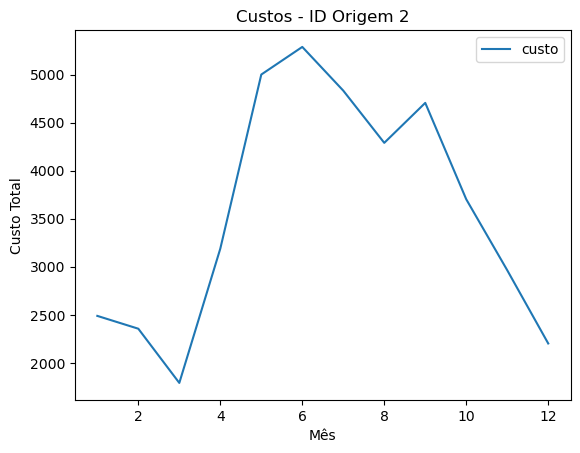

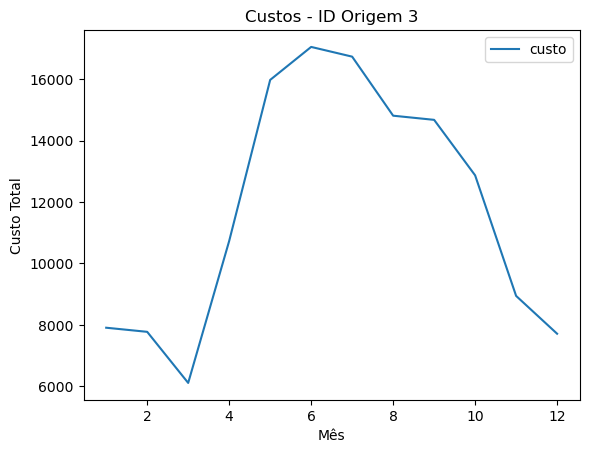

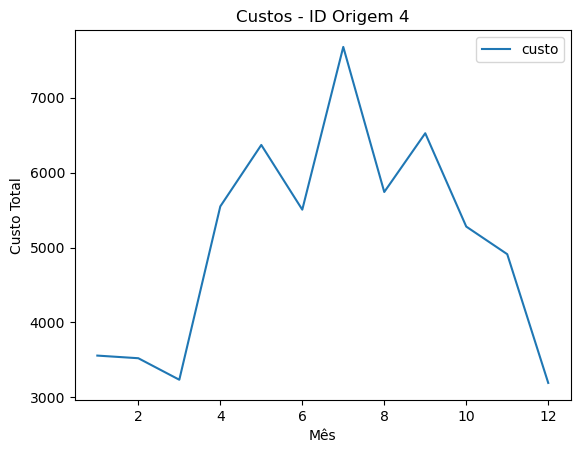

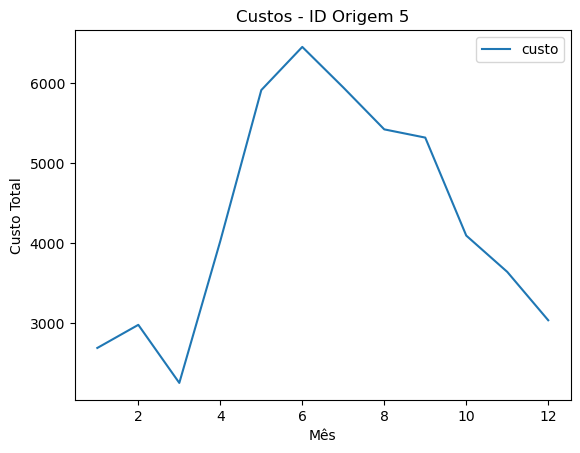

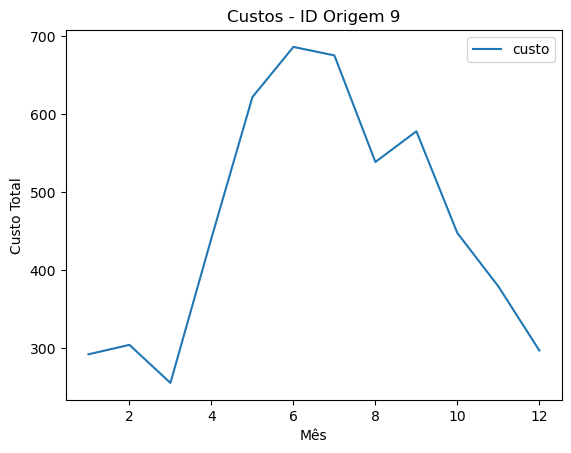

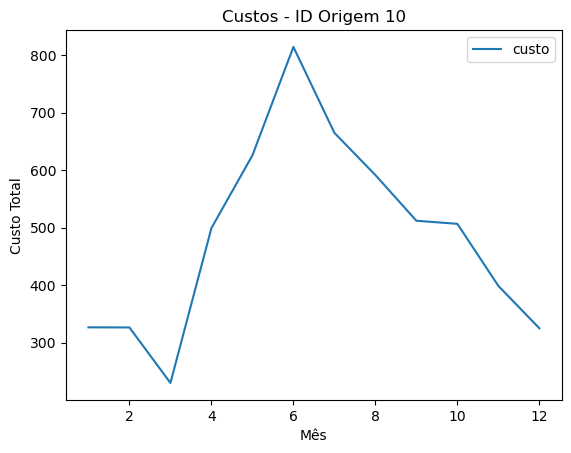

In [1639]:
for num in id:
    a=custos[custos['id_origem']==num]
    plotdf=a.pivot_table(index=['mes'], values='custo',aggfunc='sum')
    
    plotdf.plot()
    plt.title(f'Custos - ID Origem {num}')
    plt.xlabel('Mês')
    plt.ylabel('Custo Total')
    plt.show()


## indicando qual a origem de marketing que foi mais eficiente:

[sumario](#back)

observo que as propagandas foram distribuidas de forma muito parecida entre as diferentes origens, sendo os meses 5, 6 e 7(outubro novembro e dezembro) os que tiveram mais investimentos.
Entretanto, apenas os coortes dos meses 1, 4 e 7 tiveram bons desempenhos.
assim concluo que as que tiveram proporcionalmente mais investimentos nesses meses e não nos outros são mais eficientes. olhando as tabelas escolho a __origen: 4 como a mais eficiente__ 

como foi a eficiencia em geral do produto e do site?
16% dos usuarios chegam a comprar alguma coisa, desses apenas 17% compram de novo.
alem disso, apenas 22% dos que acessaram o site, acessam uma segunda vez.
não tão boa.